# Система оценки рисков ДТП

**Заказчик** — каршеринговая компания.

**Цель работы:** создание системы для оценки вероятности получения повреждений транспортного средства по выбранному маршруту движения.

**Постановка задачи заказчиком** оценка возможности предсказывать ДТП, опираясь на исторические данные одного из регионов.
1. Создать ML предсказания ДТП (целевое значение — `'at_fault'` (виновник) в таблице parties)
    - Для ML выбрать тип виновника — только машина (car).
    - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа `SCRATCH` (царапина).
    - Использовать данные за 2012 год.
    - Учесть фактор возраста автомобиля.
2. На основе ML исследовать основные факторы ДТП.
3. По результатам моделирования и анализа важности факторов ответить на вопросы:
    - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    - Какие ещё факторы нужно учесть?
    - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

**Дано:** краткое описание таблиц:
- Общая информация о ДТП, таблица `collisions`. Имеет уникальный `'case_id'`. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
- Информация об участниках ДТП, таблица `parties`. Имеет неуникальный `'case_id'`, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `'case_id'`. Если нужен уникальный идентификатор, это `'case_id'` and `'party_number'`.
- Информация о пострадавших машинах, таблица `vehicles`. Имеет неуникальные `'case_id'` и неуникальные `'party_number'`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Если нужен уникальный идентификатор, это `'case_id'` and `'party_number'`.

**Этапы выполнения проекта:**
1. Загрузка таблицы SQL.
2. Первичное исследование таблиц, используя sql-запросы.
    - Все ли таблицы имеют набор данных;
    - Соответствует ли количество таблиц условию задачи;
    - Имеется ли общий ключ для связи таблиц.
3. Статистический анализ факторов ДТП.
    - Определить, в какие месяцы происходит наибольшее количество аварий. Анализ всего периода наблюдений (таблица collisions):
        - Создание sql-запроса;
        - Построение графика;
        - Написание вывода.
    - Создание аналитических задач для получения дополнительной информации (не менее 6). Прописать порядок решения для двух задач из списка (решение задач должно включать связь не менее 2-х таблиц):
        - Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
        - Определение самых частых причин ДТП (таблица parties).
4. Создание модели оценки водительского риска.
    - Подготовка набора данных на основе первичного предположения заказчика с использованием sql-запросов:
        - Выбор типа виновника — только машина (car).   
        - Выбор случаев, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
        - Фильтрация данных за 2012 год.
    - Первичный отбор факторов, необходимых для модели, с аргументацией выбора.
    - Статистическое исследование отобранных факторов:
        - Внесение корректировок, если они требуются. Написание вывода.
        - Категоризация и масштабирование исходных данных, если требуется.
        - Подготовка обучающей и тестовой выборок.
5. Выбор лучшей модели из не менее 3-х типов с перебором гиперпараметров. Выбор метрик для оценки модели, исходя из поставленной бизнесом задачи. Обоснование выбора. Оформление вывода в виде сравнительной таблицы.
6. Проверка лучшей модели в работе.
    - Построить «Матрицу ошибок» и график полноты и точности.
    - Проанализировать важность основных факторов, влияющих на вероятность ДТП.
    - Для одного из выявленных важных факторов выполнить дополнительное исследование:
        - Построить график зависимости фактора и целевой переменной.
        - Предложить, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.
7. Написание общего вывода по модели:
    - Краткое описание лучшей модели.
    - Написание вывода: насколько возможно создание адекватной системы оценки риска при выдаче авто?
    - Определить, какие факторы ещё необходимо собирать, чтобы улучшить модель?

## Подключение к базе данных. Загрузка таблиц SQL

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import phik
import os
import warnings
import optuna
import time
import sklearn.preprocessing as pr_ng
import category_encoders as ce
import lightgbm as lgb
import xgboost as xgb
import shap

from sklearn.metrics import recall_score, make_scorer, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier
from plotly.offline import iplot
from scipy import stats as st
from sqlalchemy import create_engine
from optuna.samplers import TPESampler
from optuna import TrialPruned
from optuna.pruners import ThresholdPruner, SuccessiveHalvingPruner

shap.initjs()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 100)
warnings.filterwarnings('ignore')

RANDOM_STATE = 73

In [3]:
# Создание подключения к базе данных
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-vehicle-db'
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

## Проведение первичного исследования таблиц

### Первичное исследование таблицы `case_ids`

In [5]:
case_ids = '''
SELECT table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE';
'''
case_ids = pd.read_sql_query(case_ids, con=engine)
case_ids.head()

,table_name
0,pg_type
1,pg_foreign_table
2,pg_amop
3,pg_amproc
4,pg_language


In [3]:
case_ids = '''
SELECT * 
FROM case_ids
LIMIT 10000;
'''
case_ids = pd.read_sql_query(case_ids, con=engine)
case_ids.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [4]:
print('Вывод общей информации для таблицы \'case_ids\'', '\n')
case_ids.info()

Вывод общей информации для таблицы 'case_ids' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


In [5]:
# Основные статистики категориальных признаков
case_ids.describe(include = ['object']).transpose()

,count,unique,top,freq
case_id,1400000,1400000,0081715,1
db_year,1400000,1,2021,1400000


Таблица включает 2 столбца и 1400000 строк. Пропуски отсутствуют. Типы данных включают 2 столбца `object`.

Согласно признаку `'db_year'`, вероятно данные были выгружены в 2021 году.

### Первичное исследование таблицы `vehicles`

In [6]:
vehicles = '''
SELECT * 
FROM vehicles
LIMIT 10000;
'''
vehicles = pd.read_sql_query(vehicles, con=engine)
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [7]:
print('Вывод общей информации для таблицы \'vehicles\'', '\n')
vehicles.info()

Вывод общей информации для таблицы 'vehicles' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


In [8]:
# Количество и доля пропусков в данных
passes_share = pd.DataFrame(vehicles.isna().sum(), columns=['passes'])
passes_share['share_%'] = passes_share['passes'] * 100 / len(vehicles)
passes_share.style.background_gradient('coolwarm')

,passes,share_%
id,0,0.000000
case_id,0,0.000000
party_number,0,0.000000
vehicle_type,0,0.000000
vehicle_transmission,23659,2.316707
vehicle_age,24582,2.407088


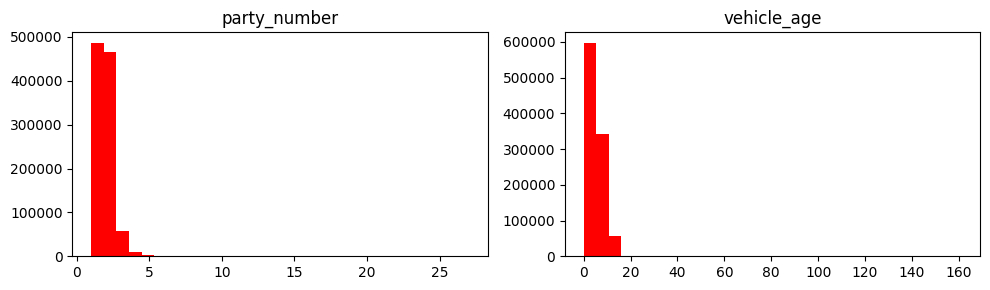

,count,mean,std,min,25%,50%,75%,max
party_number,1021234.0,1.61,0.68,1.0,1.0,2.0,2.0,27.0
vehicle_age,996652.0,5.14,3.11,0.0,3.0,5.0,7.0,161.0


In [9]:
# Озновные статистики числовых признаков
vehicles.drop(['id'],axis=1).hist(figsize=(10, 3), bins=30, grid=False, color='red');
plt.tight_layout()
plt.show()

vehicles.drop(['id'],axis=1).describe().round(2).transpose()

In [10]:
# Основные статистики категориальных признаков
vehicles.drop(['vehicle_age','party_number'],axis=1).astype('object').describe(include = ['object']).transpose()

,count,unique,top,freq
id,1021234,1021234,1175713,1
case_id,1021234,792642,5196744,27
vehicle_type,1021234,5,sedan,488665
vehicle_transmission,997575,2,auto,502243


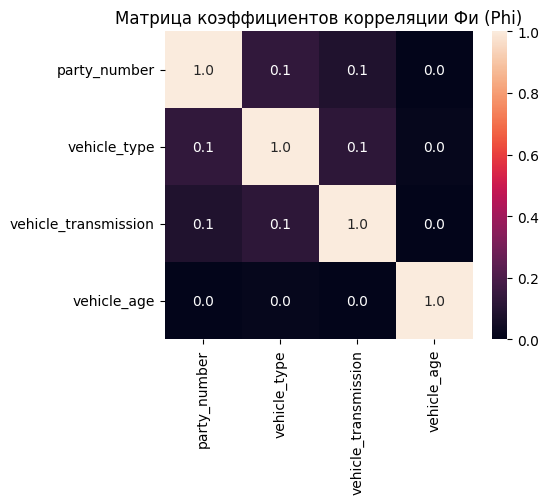

In [11]:
f, ax = plt.subplots(figsize=(5, 4))
phik_matrix = vehicles.drop(['id','case_id'],axis=1).phik_matrix(interval_cols=['vehicle_age'])
sns.heatmap(phik_matrix, vmin=0, vmax=1, square=True, annot=True, fmt='.1f')
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

Таблица включает 6 столбцов и 1021234 строк. Пропуски присутствуют у двух признаков. Типы данных включают: 2 столбца `int64`, 3 столбца `object`, 1 столбец `float64`.

Из полученных данных сомнительным кажется максимальный возраст автомобиля, что требует уточнения.

### Первичное исследование таблицы `parties`

In [12]:
parties = '''
SELECT * 
FROM parties
LIMIT 10000;
'''
parties = pd.read_sql_query(parties, con=engine)
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [13]:
print('Вывод общей информации для таблицы \'parties\'', '\n')
parties.info()

Вывод общей информации для таблицы 'parties' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


In [14]:
# Количество и доля пропусков в данных
passes_share = pd.DataFrame(parties.isna().sum(), columns=['passes'])
passes_share['share_%'] = passes_share['passes'] * 100 / len(parties)
passes_share.style.background_gradient('coolwarm')

,passes,share_%
id,0,0.000000
case_id,0,0.000000
party_number,0,0.000000
party_type,3622,0.131594
at_fault,0,0.000000
insurance_premium,405402,14.728994
party_sobriety,73955,2.686920
party_drug_physical,2320120,84.294189
cellphone_in_use,511637,18.588705


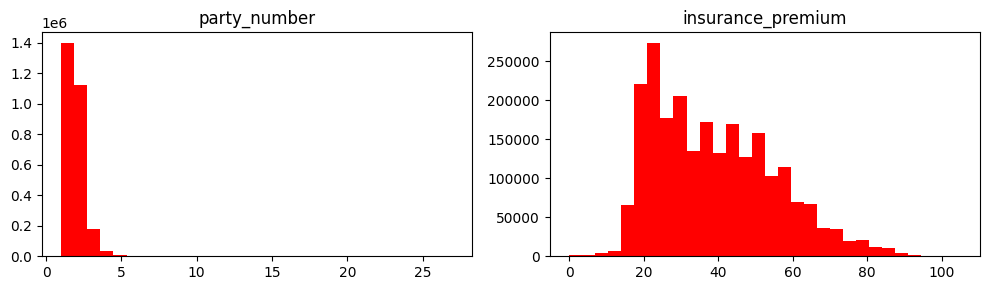

,count,mean,std,min,25%,50%,75%,max
party_number,2752408.0,1.60,0.72,1.0,1.0,1.0,2.0,27.0
insurance_premium,2347006.0,38.75,16.38,0.0,25.0,36.0,50.0,105.0


In [15]:
# Озновные статистики числовых признаков
parties.drop(['id','at_fault','cellphone_in_use'],axis=1).hist(figsize=(10, 3), bins=30, grid=False, color='red');
plt.tight_layout()
plt.show()

parties.drop(['id','at_fault','cellphone_in_use'],axis=1).describe().round(2).transpose()

In [16]:
# Основные статистики категориальных признаков
parties.drop(['party_number','insurance_premium'],axis=1).astype('object').describe(include = ['object']).transpose()

,count,unique,top,freq
id,2752408,2752408,22,1
case_id,2752408,1400000,5196744,27
party_type,2748786,5,car,2469314
at_fault,2752408,2,0,1464281
party_sobriety,2678453,6,had not been drinking,2124727
party_drug_physical,432288,5,G,232901
cellphone_in_use,2240771.0,2.0,0.0,2194946.0


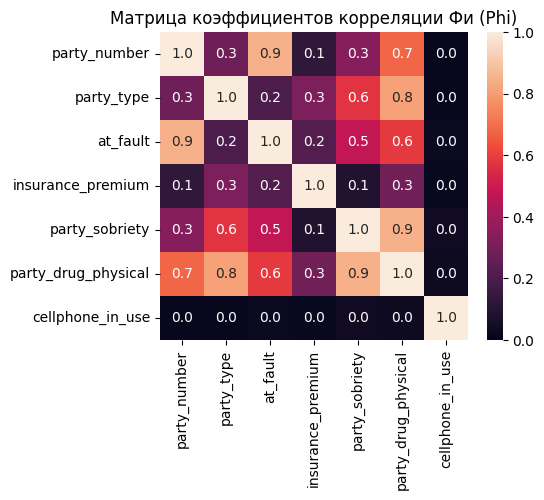

In [17]:
f, ax = plt.subplots(figsize=(5, 4))
phik_matrix = parties.drop(['id','case_id'],axis=1).phik_matrix(interval_cols=['insurance_premium'])
sns.heatmap(phik_matrix, vmin=0, vmax=1, square=True, annot=True, fmt='.1f')
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

<img src="output2.png" alt="Output Image">

Таблица включает 9 столбцов и 2752408 строк. Пропуски присутствуют у 5 признаков. Типы данных включают: 3 столбца `int64`, 4 столбца `object`, 2 столбца `float64`.

### Первичное исследование таблицы `collisions`

In [18]:
collisions = '''
SELECT * 
FROM collisions
LIMIT 10000;
'''
collisions = pd.read_sql_query(collisions, con=engine)
collisions.head(3)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


In [19]:
print('Вывод общей информации для таблицы \'collisions\'', '\n')
collisions.info()

Вывод общей информации для таблицы 'collisions' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  objec

In [20]:
# Количество и доля пропусков в данных
passes_share = pd.DataFrame(collisions.isna().sum(), columns=['passes'])
passes_share['share_%'] = passes_share['passes'] * 100 / len(collisions)
passes_share.style.background_gradient('coolwarm')

,passes,share_%
case_id,0,0.000000
county_city_location,0,0.000000
county_location,0,0.000000
distance,0,0.000000
direction,340642,24.331571
intersection,12219,0.872786
weather_1,7259,0.518500
location_type,881221,62.944357
collision_damage,0,0.000000
party_count,0,0.000000


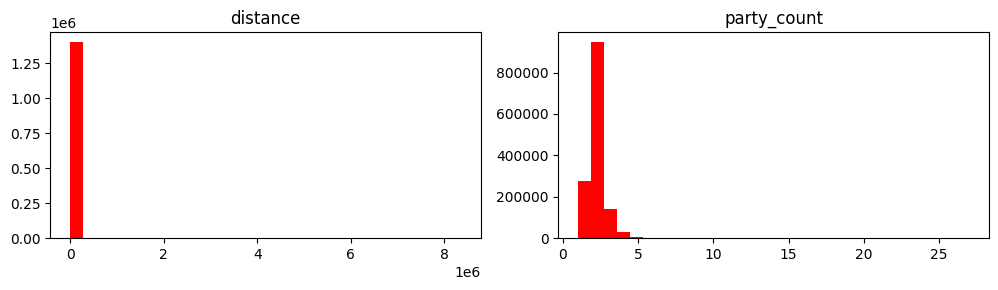

,count,mean,std,min,25%,50%,75%,max
distance,1400000.0,660.71,11785.79,0.0,2.0,100.0,430.0,8363520.0
party_count,1400000.0,1.97,0.67,1.0,2.0,2.0,2.0,27.0


In [21]:
# Озновные статистики числовых признаков
collisions.drop(['case_id','intersection'],axis=1).hist(figsize=(10, 3), bins=30, grid=False, color='red');
plt.tight_layout()
plt.show()

collisions.drop(['case_id','intersection'],axis=1).describe().round(2).transpose()

In [22]:
# Основные статистики категориальных признаков
collisions.drop(['distance','party_count'],axis=1).astype('object').describe(include = ['object']).transpose()

,count,unique,top,freq
case_id,1400000,1400000,4083072,1
county_city_location,1400000,538,1942,170335
county_location,1400000,58,los angeles,433809
direction,1059358,4,south,290513
intersection,1387781.0,2.0,0.0,1075657.0
weather_1,1392741,7,clear,1121048
location_type,518779,3,highway,416531
collision_damage,1400000,5,small damage,845771
primary_collision_factor,1391834,5,vehicle code violation,1316453
pcf_violation_category,1372046,23,speeding,438439


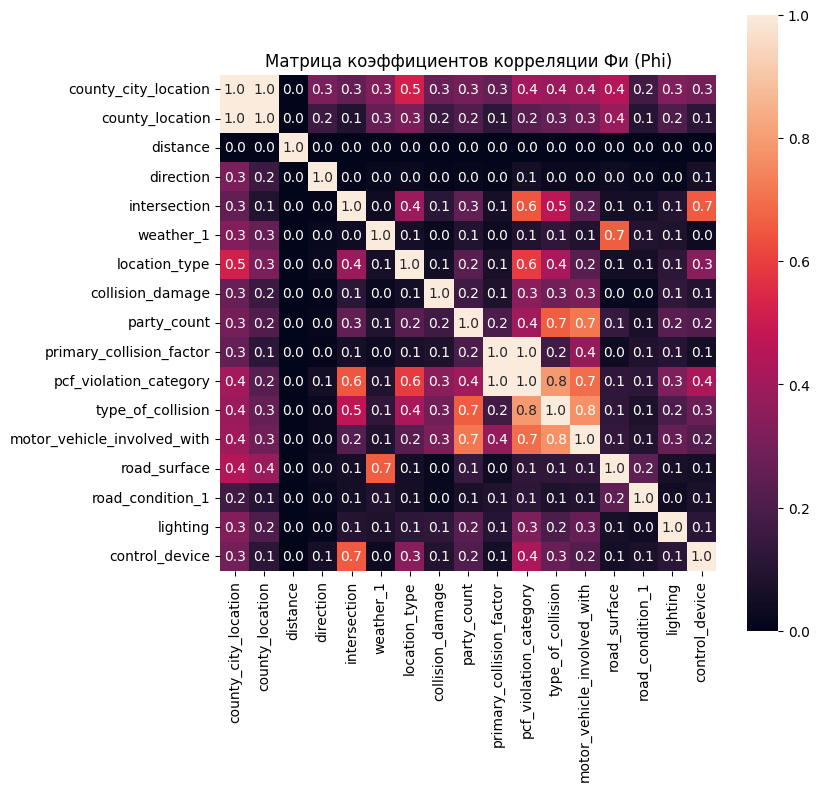

In [23]:
f, ax = plt.subplots(figsize=(8, 8))
phik_matrix = collisions.drop(['case_id','collision_date','collision_time'], axis=1).phik_matrix(interval_cols=['distance'])
sns.heatmap(phik_matrix, vmin=0, vmax=1, square=True, annot=True, fmt='.1f')
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

Таблица включает 20 столбцов и 1400000 строк. Пропуски присутствуют у 13 признаков. Типы данных включают: 1 столбец `int64`, 17 столбцов `object`, 2 столбца `float64`.

Тепловая карта показывает очень сильную корреляцию между признаками `'county_location'`/`'county_city_location'` и `'pcf_violation_category'`/`'primary_collision_factor'`. В первом случае два признака полностью дублируют друг друга, во втором случае один признак по сути является обобщающей формой второго.

### Вывод

Набор данных соответствует четырём таблицам баз данных, где каждый столбец таблицы соответствует отдельной переменной, обозначенной в условии задачи:
- `case_ids` - идентификатор обращения;
- `vehicles` - описание автомобиля;
- `parties` - описание участников происшествия;
- `collisions` - информация о происшествиях.

Для всех таблиц характерно наличие общего ключа `'case_id'`, связывающий их между собой через промежуточную таблицу `case_ids`.

Таблица `case_ids` содержит признак `'db_year'`, описание котрого отсутствует в представленном задании.

Количество записей в промежуточной таблице `case_ids` и таблице, содержащей информацию о происшествии `collisions` совпадают, поскольку `collisions` содержит базовую информацию для текущего исследования. Таблица `vehicles` содержит меньше записей, что говорит о том, что довольно большая часть ДТП происходит при участии одного транспортного средства. Таблица `parties` содержит практически в двое большее количество записей, чем в таблице `collisions`, что говорит, что в событиях в среднем учувствуют как минимум два человека (стороны происшествия).

Обнаружена сильная корреляцию в таблице `collisions` между признаками `'county_location'`/`'county_city_location'` и `'pcf_violation_category'`/`'primary_collision_factor'`. В первом случае два признака полностью дублируют друг друга, во втором случае один признак по сути является обобщающей формой второго.

## Статистический анализ факторов ДТП

Факторы ДТП - это различные обстоятельства, условия и причины, которые прямо или косвенно влияют на возникновение дорожно-транспортного происшествия.

Для достижения поставленной цели, требуется проанализировать следующие факторы риска:
- Человеческий фактор: усталость, стресс, алкоголь, наркотические вещества или медицинские препараты, влияющие на концентрацию внимания и реакцию водителя.
- Техническое состояние транспортного средства: неисправности тормозной системы, рулевого управления, световых приборов и других систем автомобиля.
- Плохие дорожные условия: скользкое покрытие, ямы, неровности, отсутствие разметки или знаков, недостаточное освещение.
- Неправильные действия других участников дорожного движения: нарушение правил дорожного движения, агрессивное вождение, несоблюдение дистанции и скоростного режима.
- Природные факторы: неблагоприятные погодные условия (сильный ветер, дождь, снег, туман), ограниченная видимость из-за растительности или особенностей ландшафта.
- Недостаточная подготовка водителей: отсутствие навыков вождения в сложных условиях, незнание правил дорожного движения и мер безопасности.
- Технические проблемы: проблемы с электроникой, механические поломки, вызванные износом или некачественным обслуживанием автомобиля.

In [24]:
def creation_MW_matrix(df: pd.DataFrame, grouping_feature: str, research_feature: str) -> pd.DataFrame:
    '''
    Create a matrix of the Mann-Whitney test for comparing samples of a grouping_feature
    df: pd.DataFrame - table with feature
    grouping_feature: str - grouping feature
    research_feature: str - research feature
    return pd.DataFrame - DataFrame with significance criteria
    '''
    grouped_data = df.groupby(grouping_feature) # Группируем данные
    mannwhitney_matrix = [] # Список для генерации итоговой матрицы
    for month, group in grouped_data: # Проходим по каждому месяцу
        values_month = group[research_feature]
        mannwhitney_values = []
        for other_month, other_group in grouped_data: # Сравниваем месяц с каждым другим месяцем
            if other_month == month: # Одинаковые месяцы заполняем пустым значением
                mannwhitney_values.append(None)
            else:
                other_values = other_group[research_feature]
                stat, p_value = st.mannwhitneyu(values_month, other_values)
                mannwhitney_values.append(p_value)
        mannwhitney_matrix.append(mannwhitney_values)
    # Формируем DF и присваиваем ему обозначения
    columns = [str(month) for month in grouped_data.groups.keys()]
    mannwhitney_matrix = pd.DataFrame(pd.DataFrame(mannwhitney_matrix, columns=columns, index=columns).round(2))
    # Улучшаем читабельность матрицы, заменой повторных значений на -
    delta = 0
    for val_y in range(len(mannwhitney_matrix)):
        val_x = 0 + delta
        for _ in range(len(mannwhitney_matrix)):
            if val_x >= len(mannwhitney_matrix):
                break
            else:
                mannwhitney_matrix.iloc[val_x, val_y] = '-'
                val_x += 1
        delta += 1
    return mannwhitney_matrix

def contingency_table_(df: pd.DataFrame, target: str, feature: str) -> pd.DataFrame:
    '''
    Contingency table of a categorical feature
    df: pd.DataFrame - table with sign
    feature: str - considered feature
    return pd.DataFrame - contingency_table
    '''
    contingency_table = pd.crosstab(df[feature], df[target])
    contingency_table.columns = ['count_0', 'count_1']
    contingency_table['count'] = contingency_table['count_0'] + contingency_table['count_1']
    contingency_table['count_%'] = np.round((contingency_table['count'] * 100) / len(df), 1)
    contingency_table = contingency_table[['count', 'count_%', 'count_0', 'count_1']]
    contingency_table['count_%_0'] = np.round((contingency_table['count_0'] * 100) / len(df[df[target] == 0]), 1)
    contingency_table['count_%_1'] = np.round((contingency_table['count_1'] * 100) / len(df[df[target] == 1]), 1)
    contingency_table['0/1'] = np.round((contingency_table['count_0'] / contingency_table['count_1']), 1)
    contingency_table = contingency_table.sort_values(by='count', ascending=False)
    contingency_table = contingency_table.replace([np.inf, -np.inf], np.nan)
    return display(contingency_table)

def chi2_test_(df: pd.DataFrame, target: str, feature: str) -> str:
    '''
    Chi-square test
    df: pd.DataFrame - table with feature
    feature: str - considered feature
    return str - statistics on chi-square test
    '''
    stat, p_val, dof, expected = st.chi2_contingency(pd.crosstab(df[feature], df[target]))
    print(f'Критерий хи-квадрат для признака \'{feature}\': Statistics = {int(stat)}, p_val = {p_val.round(2)}')
    if p_val > 0.05:
        print('Вероятность ошибки первого рода больше 5% и нет оснований отклонять гипотезу H0')
    else:
        print('Выявлено статистически значимое различие между группами')

def output_number_emissions_(df: pd.DataFrame, feature: str) -> int:
    '''
    Output of the number of emissions
    df: pd.DataFrame - table with feature
    feature: str - considered feature
    return: int - number of outliers
    '''
    perc_max = (np.percentile(df[feature], 75) - np.percentile(df[feature], 25)) * 1.5 + np.percentile(df[feature], 75)
    perc_min = np.percentile(df[feature], 25) - (np.percentile(df[feature], 75) - np.percentile(df[feature], 25)) * 1.5
    return df[(df[feature] > perc_max)|(df[feature] < perc_min)][feature].count()

In [ ]:
# Определим, в какие месяцы происходит наибольшее количество аварий
df_raw = '''
WITH
    tabl AS (
    SELECT
        DATE_TRUNC('month', CAST(collision_date AS timestamp))::date AS month_date,
        COUNT(case_id)
    FROM collisions AS cs
    GROUP BY DATE_TRUNC('month', CAST(collision_date AS timestamp))::date
    )
SELECT *, EXTRACT(MONTH FROM month_date)::int AS month
FROM tabl
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    bar_chart = go.Bar(x=df_raw['month_date'], y=df_raw['count'], hoverinfo='none')
    layout = go.Layout(
        title='Столбчатая диаграмма количества ДТП по месяцам',
        xaxis=dict(title='Месяц'),
        yaxis=dict(title='Количество аварий транспортных средств'),
        hovermode=False)
    fig = go.Figure(data=[bar_chart], layout=layout)
    iplot(fig)

[![imag](https://sun9-45.userapi.com/impg/tJwrkzE3wVvemD3Q41tqG92BoSF3bAI18T77TA/UNjSWdyeVJM.jpg?size=1778x450&quality=95&sign=fea27a1e123409e3748bebb077402c6d&type=album)]()

In [ ]:
# Определим, в какие месяцы происходит наибольшее количество аварий до апреля 2012
df_raw = '''
WITH
    tabl AS (
    SELECT
        DATE_TRUNC('month', CAST(collision_date AS timestamp))::date AS month_date,
        COUNT(case_id)
    FROM collisions AS cs
    WHERE DATE_TRUNC('month', CAST(collision_date AS timestamp)) < '2012.04.01'
    GROUP BY DATE_TRUNC('month', CAST(collision_date AS timestamp))::date
    )
SELECT *, EXTRACT(MONTH FROM month_date)::int AS month
FROM tabl
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('month')['count'].median(), 
        on='month', suffixes=('', '_median')
        )
    fig = px.box(df_research_sorted, y='count', color='month', width=1500, height=400, hover_data=None)
    fig.update_layout(
        xaxis_title='Номер месяца', 
        yaxis_title='Количество ДТП', 
        title='Ящечная диаграмма количества ДТП по месяцам',
        hovermode=False)
    iplot(fig)

print('Матрица значений критерий значимости Манна-Уитни:')
creation_MW_matrix(df_raw, 'month', 'count')

[![imag](https://sun9-44.userapi.com/impg/azrx5sna4Z1TgTUGzgA6FDfgrTHuxbAI-rkGKA/4KtpBDAu0OU.jpg?size=1500x400&quality=95&sign=4aa406c7d815e5013c16d5d0bcdc459c&type=album)]()

На графике видно, что с начала наблюдений (январь 2009), количество происшествий по месяцам не падает ниже 30К. С Апреля 2012 количество аварий падает ниже 30К и практически до нуля. Можно сделать вывод, что мы наблюдаем не валидные данные и их следует исключить из исследования. Статистически довольно тяжело выделить отличия по месяцам в количествах аварий, что вероятно связано с небольшим количеством лет наблюдений. Однако однозначно можно выделить октябрь месяц, что теоретически можно связать с наступлением первых минусовых температур. Самое ж низкое количество аварий можно приурочить к январю-февралю и июню и июлю.

In [27]:
# Оценим влияние состояния дороги на количество аварий в зависимости от месяца
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month,
    ROAD_SURFACE,
    COUNT(*)
FROM collisions
WHERE collision_date::date < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, ROAD_SURFACE
ORDER BY month
'''
df_raw = pd.read_sql_query(df_raw, con=engine)
df_raw_pt = df_raw.pivot_table(index='month', values='count', aggfunc='mean', columns='road_surface')

data = []
for col in df_raw_pt.columns:
    data.append(go.Bar(x=df_raw_pt.index.astype(str), y=df_raw_pt[col], name=col))
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    xaxis_title='Состояния дороги', 
    yaxis_title='Количество ДТП', 
    title='Столбчатая диаграмма количества ДТП в зависимости от состояний дорог')
iplot(fig)

Основное количество (более чем в 10 раз) аварий происходит на сухой дороге. Все остальные происшествия наблюдаются в значительно меньшем количестве и преимущественно в осенне-зимний период.

In [28]:
# Оценим влияние погоды на количество аварий
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month,
    weather_1,
    COUNT(*)
FROM collisions
WHERE DATE_TRUNC('month', CAST(collision_date AS timestamp)) < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, weather_1
ORDER BY month
'''
df_raw = pd.read_sql_query(df_raw, con=engine).fillna('other')
df_raw_pt = df_raw.pivot_table(index='month', values='count', aggfunc='mean', columns='weather_1')

data = []
for col in df_raw_pt.columns:
    data.append(go.Bar(x=df_raw_pt.index.astype(str), y=df_raw_pt[col], name=col))
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    xaxis_title='Погода', 
    yaxis_title='Количество ДТП', 
    title='Столбчатая диаграмма количества ДТП в зависимости от погоды')
iplot(fig)

Наибольшее количество аварий наблюдается при ясной погоде и несколько меньшее при облачности. Основная доля аварий, произошедших в облачную и дождевую погоду, а также в ветреную и снежную погоду, приурочена к осенне-зимнему периоду, что очевидно связанно с большей частотой данных природных явлений в обозначенный период. Аварии, произошедшие в туман, приурочены в основном к январю месяцу.

In [ ]:
# Оценим влияние освещённости на количество аварий
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month,
    LIGHTING,
    COUNT(*)
FROM collisions
WHERE DATE_TRUNC('month', CAST(collision_date AS timestamp)) < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, LIGHTING
ORDER BY month
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('lighting')['count'].median(), 
        on='lighting', suffixes=('', '_median')
        )
    fig = px.box(df_research_sorted, y='count', color='lighting', width=1000, height=400, hover_data=None)
    fig.update_layout(
        xaxis_title='Освещение', 
        yaxis_title='Количество ДТП', 
        title='Ящечная диаграмма количества ДТП в зависимости от освещения',
        hovermode=False)
    iplot(fig)

print('Матрица значений критерий значимости Манна-Уитни:')
creation_MW_matrix(df_raw, 'lighting', 'count')

[![imag](https://sun9-11.userapi.com/impg/EwNmPZAwL_4hkyNYjV7Su5tHVEt5dHZiBHxFTw/a04gghBZ8n0.jpg?size=1000x400&quality=95&sign=f7ff62522005d97d5edacd82c3ca91a8&type=album)]()

In [30]:
df_raw_pt = df_raw.pivot_table(index='month', values='count', aggfunc='mean', columns='lighting')

data = []
for col in df_raw_pt.columns:
    data.append(go.Bar(x=df_raw_pt.index.astype(str), y=df_raw_pt[col], name=col))
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    xaxis_title='Освещение', 
    yaxis_title='Количество ДТП', 
    title='Столбчатая диаграмма количества ДТП в зависимости от освещения')
iplot(fig)

Наибольшее количество ДТП наблюдается в светлое время, сильно меньшее количество ночью на освещённых дорогах и ещё меньше ночью на неосвещённых дорогах. Данная закономерность явно показывает, что количество аварий в большей степени зависит от трафика на дорогах, а освещённость будет влиять на вероятность. Однако эту вероятность можно будет просчитать, только узнав валовый трафик машин для данного признака.
Так же можно заметить некоторую динамику каждого из исследуемого фактора освещённости дорог по месяцам, что так же связанно с сезонностью и длинной светового дня. На это указывает явная сезонная динамика в тёмное время суток и практически отсутствие таковой в светлое время суток.

In [ ]:
# Оценим влияние времени суток на количество аварий
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month,
    EXTRACT(HOUR FROM collision_time)::int AS time,
    COUNT(*)
FROM collisions
WHERE DATE_TRUNC('month', CAST(collision_date AS timestamp)) < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, EXTRACT(HOUR FROM collision_time)::int
ORDER BY month, time
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('time')['count'].median(), 
        on='time', suffixes=('', '_median')
        )
    fig = px.box(df_research_sorted, y='count', color='time', width=1500, height=400, hover_data=None)
    fig.update_layout(
        xaxis_title='Время суток', 
        yaxis_title='Количество ДТП', 
        title='Ящечная диаграмма количества ДТП в зависимости от времени суток',
        hovermode=False)
    iplot(fig)

print('Матрица значений критерий значимости Манна-Уитни:')
creation_MW_matrix(df_raw, 'time', 'count')

[![imag](https://sun9-22.userapi.com/impg/70jrQ85l_-D2SRy_humvXkOI8Kuxg5soclzn5Q/HOwZMBaHKSE.jpg?size=1500x400&quality=95&sign=a6edf82f218e76a432aa13c8e620fff9&type=album)]()

Очень хорошая закономерность прослеживается изменения числа аварий от времени суток. Самое низкое число ДТП наблюдается между 23 и 5 часами ночи, резкий рост с 6 до 8 утра, когда население начинает передвижение на рабочие места, и далее с 12 до 18, что связанно с активностью транспорта и окончанием рабочих суток. Таким образом время суток может косвенно характеризовать величину трафика на дорогах, что, вероятно, является наиболее показательным фактором аварийности на дорогах.

In [ ]:
# Оценим влияние географического района на количество аварий
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month,
    county_location,
    COUNT(*)
FROM collisions
WHERE DATE_TRUNC('month', CAST(collision_date AS timestamp)) < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, county_location
ORDER BY month, county_location
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('county_location')['count'].median().reset_index(), 
        on='county_location', suffixes=('', '_median')
        ).sort_values(by='count_median')
    fig = px.box(df_research_sorted, y='count', color='county_location', width=1500, height=400, hover_data=None)
    fig.update_layout(
        xaxis_title='Географический район', 
        yaxis_title='Количество ДТП', 
        title='Ящечная диаграмма количества ДТП в зависимости от географического района',
        hovermode=False)
    iplot(fig)

[![imag](https://sun9-59.userapi.com/impg/FAnWN0X1uGEq12eyxI35a0eJxKBbQ6ZzqDXA5Q/jHx75ELvlII.jpg?size=1500x400&quality=95&sign=747590097653a1055a469192b42fd76e&type=album)]()

Сильно выделяется регион Лос Анжелес, который имеет самое большое среднее количество ДТП в месяц. Данный показатель очевидно будет коррелировать с плотностью транспорта в данных регионах, параметр, который следует получить для получения более точного прогноза вероятности ДТП.

In [ ]:
# Оценим влияние дорожного состояния на количество аварий
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month,
    road_condition_1,
    COUNT(*)
FROM collisions
WHERE DATE_TRUNC('month', CAST(collision_date AS timestamp)) < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, road_condition_1
ORDER BY month, road_condition_1
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('road_condition_1')['count'].median().reset_index(), 
        on='road_condition_1', suffixes=('', '_median')
        )
    fig = px.box(df_research_sorted, y='count', color='road_condition_1', width=1500, height=400, hover_data=None)
    fig.update_layout(
        xaxis_title='Дорожное состояние', 
        yaxis_title='Количество ДТП', 
        title='Ящечная диаграмма количества ДТП в зависимости от дорожного состояния',
        hovermode=False)
    iplot(fig)

print('Матрица значений критерий значимости Манна-Уитни:')
creation_MW_matrix(df_raw, 'road_condition_1', 'count')

[![imag](https://sun9-56.userapi.com/impg/lnZi3xO9rfyxK9gz5vML_7HpHagmrTBwKyNUUw/Pt5ed9MH3UA.jpg?size=1500x400&quality=95&sign=f87f9891e456066bcc8d5f8dfc9965b6&type=album)]()

In [34]:
df_raw_pt = df_raw.pivot_table(index='month', values='count', aggfunc='mean', columns='road_condition_1')

data = []
for col in df_raw_pt.columns:
    data.append(go.Bar(x=df_raw_pt.index.astype(str), y=df_raw_pt[col], name=col))
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    xaxis_title='Дорожное состояние', 
    yaxis_title='Количество ДТП', 
    title='Столбчатая диаграмма количества ДТП в зависимости от дорожного состояния')
iplot(fig)

Большинство происшествий происходит на дорогах с нормальным состоянием. Второе по частоте происшествий это зоны строительства и ремонта. Остальные категории значительно не отличаются. Сезонно можно выделит 1-3 месяцы с повышенным количеством ДТП на дорогах с нормальным состоянием. В случае проведения ремонтных работ, частота ТДП явно выше в весенне-летние периоды. Явная зимняя сезонность прослеживается у категории затопления.

In [35]:
# Оценим влияние типа участника происшествия на его виновность
df_raw = '''
SELECT 
    at_fault,
    party_type
FROM parties
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

contingency_table_(df_raw, 'at_fault', 'party_type')
chi2_test_(df_raw, 'at_fault', 'party_type')

,count,count_%,count_0,count_1,count_%_0,count_%_1,0/1
party_type,,,,,,,
car,2469314,89.7,1228964,1240350,83.9,96.3,1.0
road bumper,173488,6.3,171898,1590,11.7,0.1,108.1
building,48649,1.8,21322,27327,1.5,2.1,0.8
road signs,48456,1.8,33192,15264,2.3,1.2,2.2
other,8879,0.3,7118,1761,0.5,0.1,4.0


Критерий хи-квадрат для признака 'party_type': Statistics = 167237, p_val = 0.0
Выявлено статистически значимое различие между группами


Больше всего типов происшествий связанно с автомобилями (89,7%). При этом соотношения числа виновных и невиновных в авариях 50%/50%, что вполне логично, если основная доля происшествий наблюдается для двух водителей, один из которых будет виновником ДТП.

In [ ]:
# Оценим влияние суммы страховки от виновности участника
df_raw = '''
SELECT 
    at_fault,
    insurance_premium
FROM parties
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    fig = px.histogram(df_raw, x='insurance_premium', color='at_fault', nbins=200, barmode='overlay', 
                    labels={'at_fault': 'Виновник происшествия'})
    fig.update_layout(
        title='Гистограмма суммы страховок виновника и не виновника ДТП', 
        xaxis_title='Сумма страховки, тыс.дол.',
        yaxis_title='Количество участников происшествия',
        hovermode=False)
    iplot(fig)

[![imag](https://sun9-58.userapi.com/impg/sp0wLw2lK2KZcRkaTmSkwqw3h8HnrYFFpxGLaw/xLhX1TVKO6A.jpg?size=1778x450&quality=95&sign=cb2ac1dd796332e8b81c817e3cd43935&type=album)]()

Наиболее частыми выплатами для не виновных в ДТП участником находятся в диапазоне 18-48 тыс.дол., при этом наиболее частыми выплатами для винновых в авариях лиц находится в диапазоне 17-30 тыс.дол. что суммарно более чем в два раза меньше.

In [37]:
# Оценим влияние трезвости участника происшествия на его виновность
df_raw = '''
SELECT 
    at_fault,
    party_sobriety
FROM parties
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

contingency_table_(df_raw, 'at_fault', 'party_sobriety')
chi2_test_(df_raw, 'at_fault', 'party_sobriety')

,count,count_%,count_0,count_1,count_%_0,count_%_1,0/1
party_sobriety,,,,,,,
had not been drinking,2124727,77.2,1195907,928820,81.7,72.1,1.3
impairment unknown,232901,8.5,50177,182724,3.4,14.2,0.3
not applicable,169343,6.2,156542,12801,10.7,1.0,12.2
"had been drinking, under influence",112413,4.1,6467,105946,0.4,8.2,0.1
"had been drinking, impairment unknown",21419,0.8,4367,17052,0.3,1.3,0.3
"had been drinking, not under influence",17650,0.6,5706,11944,0.4,0.9,0.5


Критерий хи-квадрат для признака 'party_sobriety': Statistics = 320366, p_val = 0.0
Выявлено статистически значимое различие между группами


Доля виновников ДТП среди граждан, употреблявших алкоголь, значительно больше, чем среди тех, у кого алкоголь не был зафиксирован. При этом видно, что чем более сильное состояние опьянение зафиксировано, тем большую долю виновников аварий среди участников ДТП можно наблюдать.

In [38]:
# Оценим влияние приёма лекарств участника происшествия на его виновность
df_raw = '''
SELECT 
    at_fault,
    party_drug_physical
FROM parties
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

contingency_table_(df_raw, 'at_fault', 'party_drug_physical')
chi2_test_(df_raw, 'at_fault', 'party_drug_physical')

,count,count_%,count_0,count_1,count_%_0,count_%_1,0/1
party_drug_physical,,,,,,,
G,232901,8.5,50177,182724,3.4,14.2,0.3
not applicable,169343,6.2,156542,12801,10.7,1.0,12.2
under drug influence,13215,0.5,1054,12161,0.1,0.9,0.1
sleepy/fatigued,12641,0.5,575,12066,0.0,0.9,0.0
impairment - physical,4188,0.2,2314,1874,0.2,0.1,1.2


Критерий хи-квадрат для признака 'party_drug_physical': Statistics = 217132, p_val = 0.0
Выявлено статистически значимое различие между группами


Доля виновников ДТП среди граждан, находившихся под воздействием лекарственных средств, значительно больше, чем среди остальных групп граждан.

In [39]:
# Оценим влияние наличия телефона в автомобиле участника происшествия на его виновность
df_raw = '''
SELECT 
    at_fault,
    cellphone_in_use
FROM parties
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

contingency_table_(df_raw, 'at_fault', 'cellphone_in_use')
chi2_test_(df_raw, 'at_fault', 'cellphone_in_use')

,count,count_%,count_0,count_1,count_%_0,count_%_1,0/1
cellphone_in_use,,,,,,,
0.0,2194946,79.7,1155932,1039014,78.9,80.7,1.1
1.0,45825,1.7,21053,24772,1.4,1.9,0.8


Критерий хи-квадрат для признака 'cellphone_in_use': Statistics = 812, p_val = 0.0
Выявлено статистически значимое различие между группами


Виновников аварий среди участников, имеющих возможность разговаривать по телефону в машине на громкой связи, значимо больше, чем среди тех, кто такой возможности не имеет. Разговор по телефону во время вождения, даже с использованием громкой связи, может отвлекать внимание водителя от дороги, однако данный вопрос кажется недостаточно исследованным, для создание каких либо рекомендаций.

In [40]:
# Оценим влияние возраста автомобиля участника происшествия на его виновность
df_raw = '''
SELECT at_fault, vehicle_age
FROM parties AS ps
INNER JOIN vehicles AS vs ON ps.case_id = vs.case_id
WHERE vehicle_age < 160
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

contingency_table_(df_raw, 'at_fault', 'vehicle_age')
chi2_test_(df_raw, 'at_fault', 'vehicle_age')

,count,count_%,count_0,count_1,count_%_0,count_%_1,0/1
vehicle_age,,,,,,,
3,369722,17.3,200901,168821,16.7,18.1,1.2
4,268330,12.5,150120,118210,12.4,12.7,1.3
5,228606,10.7,130158,98448,10.8,10.5,1.3
2,222730,10.4,122536,100194,10.2,10.7,1.2
6,184367,8.6,105503,78864,8.7,8.4,1.3
7,183937,8.6,105203,78734,8.7,8.4,1.3
8,168048,7.9,96202,71846,8.0,7.7,1.3
9,126711,5.9,72579,54132,6.0,5.8,1.3
1,91383,4.3,52742,38641,4.4,4.1,1.4


Критерий хи-квадрат для признака 'vehicle_age': Statistics = 1247, p_val = 0.0
Выявлено статистически значимое различие между группами


Наибольшее число автомобилей, попавших в ДТП характерно для возрастов автомобилей от 0 до 10 лет, при этом пик приходится на 3 года. Для того что бы точно сказать, как влияет возраст автомобиля на его вероятность попасть в ДТП необходима иметь весовые коэффициенты, отражающие в целом соотношение различных возрастов автомобилей на дорогах.

In [ ]:
# Оценим влияние возраста автомобиля участника происшествия на сумму страховки
df_raw = '''
SELECT insurance_premium, vehicle_age
FROM parties AS ps
INNER JOIN vehicles AS vs ON ps.case_id = vs.case_id
WHERE vehicle_age < 160
'''
df_raw = pd.read_sql_query(df_raw, con=engine).dropna()

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('vehicle_age')['insurance_premium'].median().reset_index(), 
        on='vehicle_age', suffixes=('', '_median')
        ).sort_values(by='vehicle_age')
    fig = px.box(df_research_sorted, y='insurance_premium', color='vehicle_age', width=1500, height=400, hover_data=None)
    fig.update_layout(
        xaxis_title='Возраста автомобиля участника происшествия', 
        yaxis_title='Сумма выплаченной страховки, тыс.дол.', 
        title='Ящечная диаграмма средних возрастов автомобилей по суммам страховых выплат',
        hovermode=False)
    iplot(fig)

[![imag](https://sun9-67.userapi.com/impg/LxoZfsHRGWhdhE1M05K7e2iMv9SnqeHh92l6EQ/a8vvQnsNJTY.jpg?size=1500x400&quality=95&sign=bda9a465191571f9b0950e9db8f89506&type=album)]()

Наибольшие страховые выплаты характерны для автомобилей, возрастом 9-15 лет. После 16 летнего возраста сумма страховых выплат резко падает.

In [ ]:
# Оценим влияние дорожного состояния участника происшествия на сумму страховки
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month, 
    road_condition_1, 
    AVG(insurance_premium) AS avg_ins_prem
FROM parties AS ps
LEFT JOIN collisions AS cs ON cs.case_id = ps.case_id
WHERE cs.collision_date::date < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, road_condition_1
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('road_condition_1')['avg_ins_prem'].median().reset_index(), 
        on='road_condition_1', suffixes=('', '_median')
        ).sort_values(by='avg_ins_prem_median')
    fig = px.box(df_research_sorted, y='avg_ins_prem', color='road_condition_1', width=1000, height=400, hover_data=None)
    fig.update_layout(
        xaxis_title='Дорожное состояние', 
        yaxis_title='Сумма выплаченной страховки, тыс.дол.', 
        title='Ящечная диаграмма величины страховых выплат в зависимости от дорожного состояния',
        hovermode=False)
    iplot(fig)

print('Матрица значений критерий значимости Манна-Уитни:')
creation_MW_matrix(df_raw, 'road_condition_1', 'avg_ins_prem')

[![imag](https://sun9-29.userapi.com/impg/KO6vIBgmeHbb6Bs_CKjYPYWfH5yTOYU1ttSNOg/NRbqu74y91E.jpg?size=1000x400&quality=95&sign=e65b60b6bf3fbaba6cb02a45586c9fc1&type=album)]()

Самые большие страховые выплаты получают участники ДТП, произошедшей на участках дорог с уменьшенной шириной проезжей части. Второй по величие выплаты получают такие происшествия, которые были зафиксированы на дорогах с препятствиями, местах проведения строительных работ, имеющих ямы или глубокую колею. Самые низкие страховые выплаты характерны для ДТП на подтопленных дорогах.

In [ ]:
# Оценим самых частых причин ДТП на основе категорий нарушений
df_raw = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::int AS month, 
    pcf_violation_category,
    COUNT(*)
FROM collisions
WHERE collision_date::date < '2012.04.01'
GROUP BY EXTRACT(MONTH FROM collision_date)::int, pcf_violation_category
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('pcf_violation_category')['count'].median().reset_index(), 
        on='pcf_violation_category', suffixes=('', '_median')
        ).sort_values(by='count_median')
    fig = px.box(df_research_sorted, y='count', color='pcf_violation_category', width=1000, height=400)
    fig.update_layout(
        xaxis_title='Дорожное состояние', 
        yaxis_title='Сумма выплаченной страховки, тыс.дол.', 
        title='Ящечная диаграмма величины страховых выплат в зависимости от дорожного состояния')
    iplot(fig)

[![imag](https://sun9-33.userapi.com/impg/049SsClxCpjqOyryKcHpa3Un83L9_0-zV4HFXg/zWJU6MInd3c.jpg?size=1000x400&quality=95&sign=51a7753e2ca231f6841cebe4ef98324d&type=album)]()

Самой частой причиной ДТП является превышение скоростного режима и составляет почти 30% всех инцидентов. Вторыми самыми частыми причинами являются неправильный поворот (16%).

In [ ]:
# Оценим влияние суммы страховки от виновности участника
df_raw = '''
SELECT 
    cs.collision_damage,
    ps.insurance_premium
FROM case_ids AS cid
INNER JOIN collisions AS cs ON cid.case_id = cs.case_id
INNER JOIN parties AS ps ON cid.case_id = ps.case_id
'''
df_raw = pd.read_sql_query(df_raw, con=engine)

CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    df_research_sorted = df_raw.merge(
        df_raw.groupby('collision_damage')['insurance_premium'].median().reset_index(), 
        on='collision_damage', suffixes=('', '_median')
        ).sort_values(by='insurance_premium_median')
    fig = px.box(df_research_sorted, y='insurance_premium', color='collision_damage', width=1000, height=400)
    fig.update_layout(
        xaxis_title='Дорожное состояние', 
        yaxis_title='Сумма выплаченной страховки, тыс.дол.', 
        title='Ящечная диаграмма величины страховых выплат в зависимости от дорожного состояния')
    iplot(fig)

print('Матрица значений критерий значимости Манна-Уитни:')
creation_MW_matrix(df_raw, 'collision_damage', 'insurance_premium')

[![imag](https://sun9-73.userapi.com/impg/bzcHdSiMpnfQKBUNR-Oex73uh6tI8auTAdMamQ/LSH3FM0lAzs.jpg?size=1000x400&quality=95&sign=3b70ac38f32e24e8758536e2639737dd&type=album)]()

### Вывод

1. Имеется необходимость исключить данные до апреля 2012 года из исследования, так как они не являются валидными.
2. Основное количество (более чем в 10 раз) аварий происходит на сухой дороге. Все остальные происшествия наблюдаются в значительно меньшем количестве и преимущественно в осенне-зимний период.
3. Наибольшее количество аварий наблюдается при ясной погоде и несколько меньшее при облачности. Основная доля аварий, произошедших в облачную и дождевую погоду, а также в ветреную и снежную погоду, приурочена к осенне-зимнему периоду, что очевидно связанно с большей частотой данных природных явлений в обозначенный период. Аварии, произошедшие в туман, приурочены в основном к январю месяцу.
4. Наибольшее количество ДТП наблюдается в светлое время, сильно меньшее количество ночью на освещённых дорогах и ещё меньше ночью на неосвещённых дорогах. Данная закономерность явно показывает, что количество аварий в большей степени зависит от трафика на дорогах, а освещённость будет влиять на вероятность события. Однако эту вероятность можно будет просчитать, только узнав валовый трафик машин для данного признака. Так же можно заметить некоторую динамику каждого из исследуемого фактора освещённости дорог по месяцам, что так же связанно с сезонностью и длинной светового дня. На это указывает явная сезонная динамика в тёмное время суток и практически отсутствие таковой в светлое время суток.
5. Самое низкое число ДТП наблюдается между 23 и 5 часами ночи, резкий рост с 6 до 8 утра, далее с 12 до 18, что связанно с активностью транспорта и передвижением масс населения. Таким образом время суток может косвенно характеризовать величину трафика на дорогах, что, вероятно, является наиболее показательным фактором аварийности на дорогах.
6. Сильно выделяется регион Лос Анжелес, который имеет самое большое среднее количество ДТП в месяц. Данный показатель очевидно будет коррелировать с плотностью транспорта в данных регионах, параметр, который следует получить для получения более точного прогноза вероятности ДТП.
7. Большинство происшествий происходит на дорогах с нормальным состоянием. Второе по частоте происшествий это зоны строительства и ремонта. Остальные категории значительно не отличаются. Сезонно можно выделит 1-3 месяцы с повышенным количеством ДТП на дорогах с нормальным состоянием. В случае проведения ремонтных работ, частота ТДП явно выше в весенне-летние периоды. Явная зимняя сезонность прослеживается у категории затопления. Данный признак будет значительнее более показателен, если учитывать число аварий к величине транспортного потока в указанных местах ДТП. Или можно попробовать рассмотреть косвенные показатели, подобным пропускной способности дорог.
8. Больше всего типов происшествий связанно с автомобилями (89,7%). При этом соотношения числа виновных и невиновных в авариях 50%/50%, что вполне логично, если основная доля происшествий наблюдается для двух водителей, один из которых будет виновником ДТП.
9. Наиболее частыми выплатами для не виновных в ДТП участником находятся в диапазоне 18-48 тыс.дол., при этом наиболее частыми выплатами для винновых в авариях лиц находится в диапазоне 17-30 тыс.дол. что суммарно более чем в два раза меньше.
10. Доля виновников ДТП среди граждан, употреблявших алкоголь, значительно больше, чем среди тех, у кого алкоголь не был зафиксирован. При этом видно, что чем более сильное состояние опьянение зафиксировано, тем большую долю виновников аварий среди участников ДТП можно наблюдать.
11. Доля виновников ДТП среди граждан, находившихся под воздействием лекарственных средств, значительно больше, чем среди остальных групп граждан.
12. Виновников аварий среди участников, имеющих возможность разговаривать по телефону в машине на громкой связи, значимо больше, чем среди тех, кто такой возможности не имеет. Разговор по телефону во время вождения, даже с использованием громкой связи, может отвлекать внимание водителя от дороги, однако данный вопрос кажется недостаточно исследованным, для создание каких-либо рекомендаций.
13. Наибольшее число автомобилей, попавших в ДТП характерно для возрастов автомобилей от 0 до 10 лет, при этом пик приходится на 3 года. Для того что бы точно сказать, как влияет возраст автомобиля на его вероятность попасть в ДТП необходима иметь весовые коэффициенты, отражающие в целом соотношение различных возрастов автомобилей на дорогах.
14. Наибольшие страховые выплаты характерны для автомобилей, возрастом 9-15 лет. После 16 летнего возраста сумма страховых выплат резко падает.
15. Самые большие страховые выплаты получают участники ДТП, произошедшей на участках дорог с уменьшенной шириной проезжей части. Второй по величие выплаты получают такие происшествия, которые были зафиксированы на дорогах с препятствиями, местах проведения строительных работ, имеющих ямы или глубокую колею. Самые низкие страховые выплаты характерны для ДТП на подтопленных дорогах.
16. Самой частой причиной ДТП является превышение скоростного режима и составляет почти 30% всех инцидентов. Вторыми самыми частыми причинами являются неправильный поворот (16%).

## Создание модели оценки водительского риска

### Подготовка первичного набора данных

Отбираем ретроспективные признаки и признаки, по которым требуется выполнить фильтрацию данных.

1. Дополняем таблицу `parties` информацией из таблицы `collisions`, используя `'case_id'` и получаем 2752408 записи.
2. Дополняем таблицу `vehicles` информацией из обьединённых таблиц `parties` и `collisions`, используя `'case_id'` и `'party_number'` получаем 1021234 записи.
3. Выполнив фильтрацию по условию 'car', 'scratch' и 2012, остаётся 56248 записи.

In [45]:
df_raw = '''
WITH
  tabl AS (
    SELECT 
      ps.case_id,
      ps.party_number,
      cs.county_location,
      cs.direction,
      cs.weather_1,
      cs.location_type,
      cs.road_surface,
      cs.road_condition_1,
      cs.lighting,
      cs.control_device,
      cs.collision_date,
      cs.collision_time,
      ps.at_fault,
      ps.party_sobriety,
      ps.party_drug_physical,
      ps.cellphone_in_use,
      ps.party_type,
      cs.collision_damage
    FROM parties AS ps
    LEFT JOIN collisions AS cs ON ps.case_id = cs.case_id
  )
SELECT 
  vs.vehicle_type,
  vs.vehicle_transmission,
  vs.vehicle_age,
  tb.county_location,
  tb.direction,
  tb.weather_1,
  tb.location_type,
  tb.road_surface,
  tb.road_condition_1,
  tb.lighting,
  tb.control_device,
  tb.at_fault,
  tb.party_sobriety,
  tb.party_drug_physical,
  tb.cellphone_in_use,
  tb.party_type,
  tb.collision_damage,
  EXTRACT(MONTH FROM tb.collision_date)::int AS month,
  EXTRACT(HOUR FROM tb.collision_time)::int AS hour
FROM vehicles AS vs
LEFT JOIN tabl AS tb ON vs.case_id = tb.case_id AND vs.party_number = tb.party_number
WHERE 
  tb.party_type = 'car'
  AND tb.collision_damage != 'scratch'
  AND EXTRACT(YEAR FROM tb.collision_date) = 2012
'''
df_raw = pd.read_sql_query(df_raw, con=engine)
display(df_raw.head())
df_raw.info()

,vehicle_type,vehicle_transmission,vehicle_age,county_location,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,party_type,collision_damage,month,hour
0,coupe,auto,13.0,san diego,east,clear,None,dry,normal,daylight,none,1,had not been drinking,None,0.0,car,fatal,1,12.0
1,sedan,manual,3.0,los angeles,north,clear,None,dry,normal,daylight,none,0,had not been drinking,None,0.0,car,fatal,1,10.0
2,coupe,auto,11.0,los angeles,south,clear,highway,dry,normal,daylight,none,1,had not been drinking,None,0.0,car,severe damage,1,13.0
3,coupe,manual,6.0,alameda,None,clear,ramp,dry,normal,dark with street lights,none,1,"had been drinking, under influence",None,NaN,car,fatal,1,18.0
4,coupe,manual,6.0,nevada,south,clear,None,dry,normal,dark with no street lights,functioning,0,had not been drinking,None,0.0,car,fatal,2,18.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicle_type          56248 non-null  object 
 1   vehicle_transmission  55389 non-null  object 
 2   vehicle_age           54554 non-null  float64
 3   county_location       56248 non-null  object 
 4   direction             43230 non-null  object 
 5   weather_1             56080 non-null  object 
 6   location_type         25932 non-null  object 
 7   road_surface          55900 non-null  object 
 8   road_condition_1      55999 non-null  object 
 9   lighting              56094 non-null  object 
 10  control_device        56033 non-null  object 
 11  at_fault              56248 non-null  int64  
 12  party_sobriety        55376 non-null  object 
 13  party_drug_physical   2857 non-null   object 
 14  cellphone_in_use      51777 non-null  float64
 15  party_type         

In [46]:
# Количество и доля пропусков в данных
passes_share = pd.DataFrame(df_raw.isna().sum(), columns=['passes'])
passes_share['share_%'] = passes_share['passes'] * 100 / len(df_raw)
passes_share.style.background_gradient('coolwarm')

,passes,share_%
vehicle_type,0,0.000000
vehicle_transmission,859,1.527165
vehicle_age,1694,3.011663
county_location,0,0.000000
direction,13018,23.143934
weather_1,168,0.298677
location_type,30316,53.897027
road_surface,348,0.618689
road_condition_1,249,0.442682
lighting,154,0.273788


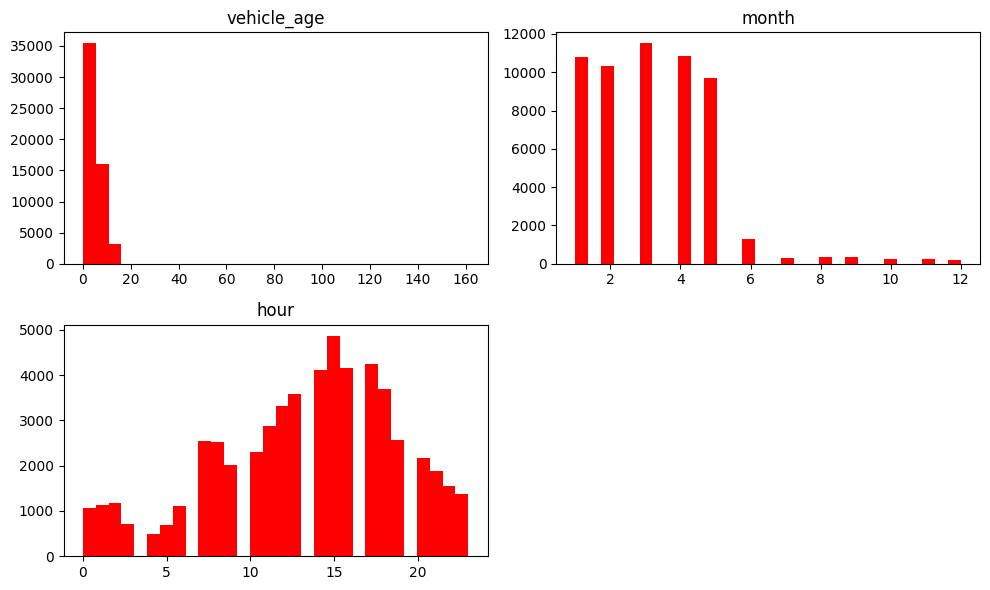

,count,mean,std,min,25%,50%,75%,max
vehicle_age,54554.0,4.86,3.23,0.0,3.0,4.0,7.0,161.0
month,56248.0,3.23,1.81,1.0,2.0,3.0,4.0,12.0
hour,56160.0,13.32,5.53,0.0,10.0,14.0,17.0,23.0


In [47]:
# Озновные статистики числовых признаков
df_raw.drop(['at_fault','cellphone_in_use'],axis=1).hist(figsize=(10, 6), bins=30, grid=False, color='red');
plt.tight_layout()
plt.show()

df_raw.drop(['at_fault','cellphone_in_use'],axis=1).describe().round(2).transpose()

In [48]:
# Основные статистики категориальных признаков
df_raw.drop(['vehicle_age','month','hour','party_type','collision_damage'],axis=1).astype('object').describe(include = ['object']).transpose()

,count,unique,top,freq
vehicle_type,56248,3,sedan,37180
vehicle_transmission,55389,2,manual,29318
county_location,56248,58,los angeles,16236
direction,43230,4,north,12129
weather_1,56080,7,clear,45092
location_type,25932,3,highway,21323
road_surface,55900,4,dry,50242
road_condition_1,55999,8,normal,54066
lighting,56094,5,daylight,38064
control_device,56033,4,none,37578


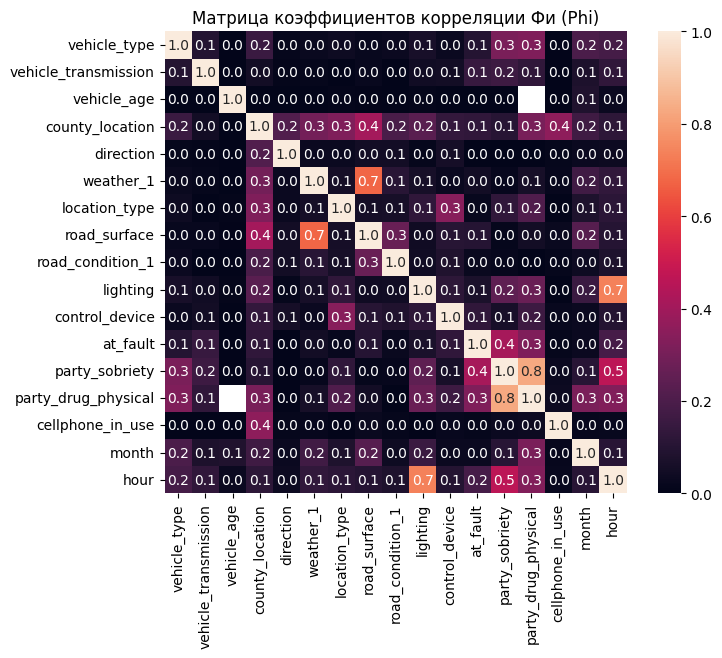

In [49]:
f, ax = plt.subplots(figsize=(8, 6))
phik_matrix = df_raw.drop(['party_type','collision_damage'],axis=1).phik_matrix(interval_cols=['vehicle_age'])
sns.heatmap(phik_matrix, vmin=0, vmax=1, square=True, annot=True, fmt='.1f')
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

Сформированная, по рекомендациям заказчика, база данных включает 56248 наблюдения и 17 ретроспективных признака. Тем не менее база данных имеет явные недостатки:
- малое количество наблюдений. Не учитываются результаты наблюдений на предыдущие годы;
- данные представлены за одни год, в котором полноценно мы видим наблюдения за первых 5 месяцев, остальные месяцы представлены крайне слабо;
- признак возраста автомобиля имеет сомнительные значения возраста, более 100 лет.

### Предварительныя обработка данных

In [50]:
# Подчищае строчные данные
df_raw = df_raw.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
df_raw = df_raw.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

# Обработка пропусков
df_raw.vehicle_transmission = df_raw.vehicle_transmission.fillna('unknown')
df_raw.direction = df_raw.direction.fillna('unknown')
df_raw.weather_1 = df_raw.weather_1.fillna('other')
df_raw.location_type = df_raw.location_type.fillna('unknown')
df_raw.road_surface = df_raw.road_surface.fillna('unknown')
df_raw.road_condition_1 = df_raw.road_condition_1.fillna('other')
df_raw.lighting = df_raw.lighting.fillna('unknown')
df_raw.control_device = df_raw.control_device.fillna('none')
df_raw.party_sobriety = df_raw.party_sobriety.fillna('not applicable')
df_raw.party_drug_physical = df_raw.party_drug_physical.fillna('not applicable')
df_raw.cellphone_in_use = df_raw.cellphone_in_use.fillna(0)
df_raw = df_raw.dropna() # Оставшиеся 3,17% пропусков ршено удалить

### Разведочный анализ данных

#### Тип кузова автомобиля `'vehicle_typer'`

In [51]:
bar_chart = go.Bar(
    x=df_raw.vehicle_type.value_counts().sort_index().index,
    y=df_raw.vehicle_type.value_counts().sort_index().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий автомобилей с различными типами кузовов',
    xaxis=dict(title='Тип кузова автомобиля'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=300)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.vehicle_type.nunique())
print('Уникальные значения признака:', '\n', df_raw.vehicle_type.sort_values().unique())

Количество уникальных значений признаков: 3
Уникальные значения признака: 
 ['coupe' 'other' 'sedan']


Типы кузовоп представленны двумя значениями coupe и sedan. Неизвестный тип кузова представлен 4 единицами и есть смысл эти данные исключить.

#### Тип КПП `'vehicle_transmission'`

In [52]:
bar_chart = go.Bar(
    x=df_raw.vehicle_transmission.value_counts().sort_index().index,
    y=df_raw.vehicle_transmission.value_counts().sort_index().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий автомобилей с различным типом КПП',
    xaxis=dict(title='Тип КПП'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=300)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.vehicle_transmission.nunique())
print('Уникальные значения признака:', '\n', df_raw.vehicle_transmission.sort_values().unique())

Количество уникальных значений признаков: 3
Уникальные значения признака: 
 ['auto' 'manual' 'unknown']


Типы КПП представленны двумя значениями (auto и manual) приблизительно со схожем соотношении.

#### Возраст автомобиля `'vehicle_age'`

In [53]:
fig = px.histogram(df_raw, x='vehicle_age', nbins=200, barmode='overlay', 
                   labels={'at_fault': 'Виновник происшествия'})
fig.update_layout(
    title='Столбчатая диаграмма частот аварий автомобилей с различным возрастом', 
    xaxis_title='Возраст автомобиля',
    yaxis_title='Количество аварий')
iplot(fig)

print('Количество выбросов:', output_number_emissions_(df_raw, 'vehicle_age'))

df_raw.vehicle_age.describe(percentiles=[.25,.75]).round(1)

Количество выбросов: 329


count    54470.0
mean         4.9
std          3.2
min          0.0
25%          3.0
50%          4.0
75%          7.0
max        161.0
Name: vehicle_age, dtype: float64

Средний возраст автомобилей рассматриваемой таблицы 4,9 года. Наибольшая частота аварий характерна для трёхлетних автомобилей. Редкие значения возрастов (старше 15 лет) вероятно стоит убрать.

#### Название географического района, где произошло ДТП `'county_location'`

In [54]:
bar_chart = go.Bar(
    x=df_raw.county_location.value_counts().sort_values().index,
    y=df_raw.county_location.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот таварий в различных географических регионах',
    xaxis=dict(title='Название географического района'),
    yaxis=dict(title='Количество аварий'),
    width=1500, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.county_location.nunique())
print('Уникальные значения признака:', '\n', df_raw.county_location.sort_values().unique())

Количество уникальных значений признаков: 58
Уникальные значения признака: 
 ['alameda' 'alpine' 'amador' 'butte' 'calaveras' 'colusa' 'contra costa'
 'del norte' 'el dorado' 'fresno' 'glenn' 'humboldt' 'imperial' 'inyo'
 'kern' 'kings' 'lake' 'lassen' 'los angeles' 'madera' 'marin' 'mariposa'
 'mendocino' 'merced' 'modoc' 'mono' 'monterey' 'napa' 'nevada' 'orange'
 'placer' 'plumas' 'riverside' 'sacramento' 'san benito' 'san bernardino'
 'san diego' 'san francisco' 'san joaquin' 'san luis obispo' 'san mateo'
 'santa barbara' 'santa clara' 'santa cruz' 'shasta' 'sierra' 'siskiyou'
 'solano' 'sonoma' 'stanislaus' 'sutter' 'tehama' 'trinity' 'tulare'
 'tuolumne' 'ventura' 'yolo' 'yuba']


Наибольшая частота аварий характерна для региона los angeles.

#### Направление движения во время ДТП `'direction'`

In [55]:
bar_chart = go.Bar(
    x=df_raw.direction.value_counts().sort_values().index,
    y=df_raw.direction.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по направлениям движений',
    xaxis=dict(title='Направление движения'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.direction.nunique())
print('Уникальные значения признака:', '\n', df_raw.direction.sort_values().unique())

Количество уникальных значений признаков: 5
Уникальные значения признака: 
 ['east' 'north' 'south' 'unknown' 'west']


Большинство направлений движений при авариях не известно, вероятно по той причини что авария произошла на перекрёстке и определить направление движения невозможно.

#### Погода `'weather_1'`

In [56]:
bar_chart = go.Bar(
    x=df_raw.weather_1.value_counts().sort_values().index,
    y=df_raw.weather_1.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по направлениям движений',
    xaxis=dict(title='Направление движения'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.weather_1.nunique())
print('Уникальные значения признака:', '\n', df_raw.weather_1.sort_values().unique())

Количество уникальных значений признаков: 7
Уникальные значения признака: 
 ['clear' 'cloudy' 'fog' 'other' 'raining' 'snowing' 'wind']


Основное количество ДТП наблюдается в ясную и облачную погоду.

#### Тип дороги `'location_type'`

In [57]:
bar_chart = go.Bar(
    x=df_raw.location_type.value_counts().sort_values().index,
    y=df_raw.location_type.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по направлениям движений',
    xaxis=dict(title='Направление движения'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.location_type.nunique())
print('Уникальные значения признака:', '\n', df_raw.location_type.sort_values().unique())

Количество уникальных значений признаков: 4
Уникальные значения признака: 
 ['highway' 'intersection' 'ramp' 'unknown']


Основная доля ДТП наблюдается на дорогах общего пользования, вне перекрёстков и рамп.

#### Состояние дороги `'road_surface'`

In [58]:
bar_chart = go.Bar(
    x=df_raw.road_surface.value_counts().sort_values().index,
    y=df_raw.road_surface.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по состояниям дороги',
    xaxis=dict(title='Состояние дороги'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.road_surface.nunique())
print('Уникальные значения признака:', '\n', df_raw.road_surface.sort_values().unique())

Количество уникальных значений признаков: 5
Уникальные значения признака: 
 ['dry' 'slippery' 'snowy' 'unknown' 'wet']


Основная доля ДТП происходит на сухих дорогах.

#### Дорожное состояние `'road_condition_1'`

In [59]:
bar_chart = go.Bar(
    x=df_raw.road_condition_1.value_counts().sort_values().index,
    y=df_raw.road_condition_1.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по дорожным состояниям',
    xaxis=dict(title='Дорожное состояние'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.road_condition_1.nunique())
print('Уникальные значения признака:', '\n', df_raw.road_condition_1.sort_values().unique())

Количество уникальных значений признаков: 8
Уникальные значения признака: 
 ['construction' 'flooded' 'holes' 'loose material' 'normal' 'obstruction'
 'other' 'reduced width']


Основная доля ДТП происходит на дорогах в нормальном состоянии.

#### Освещение `'lighting'`

In [60]:
bar_chart = go.Bar(
    x=df_raw.lighting.value_counts().sort_values().index,
    y=df_raw.lighting.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по типу освещения дороги',
    xaxis=dict(title='Освещение'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.lighting.nunique())
print('Уникальные значения признака:', '\n', df_raw.lighting.sort_values().unique())

Количество уникальных значений признаков: 6
Уникальные значения признака: 
 ['dark with no street lights' 'dark with street lights'
 'dark with street lights not functioning' 'daylight' 'dusk or dawn'
 'unknown']


Основная доля ДТП происходит днём или на освещённых улицах.

#### Устройство управления `'control_device'`

In [61]:
bar_chart = go.Bar(
    x=df_raw.control_device.value_counts().sort_values().index,
    y=df_raw.control_device.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по типу устройства управления',
    xaxis=dict(title='Устройство управления'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.control_device.nunique())
print('Уникальные значения признака:', '\n', df_raw.control_device.sort_values().unique())

Количество уникальных значений признаков: 4
Уникальные значения признака: 
 ['functioning' 'none' 'not functioning' 'obscured']


Основная доля ДТП происходит с автомобилями у которых отсутствует устройство управления.

#### Виновность участника ДТП `'at_fault'`

In [62]:
bar_chart = go.Bar(
    x=df_raw.at_fault.value_counts().sort_values().index,
    y=df_raw.at_fault.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по типу виновности в ДТП',
    xaxis=dict(title='Виновность участника ДТП'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.at_fault.nunique())
print('Уникальные значения признака:', '\n', df_raw.at_fault.sort_values().unique())

Количество уникальных значений признаков: 2
Уникальные значения признака: 
 [0 1]


Соотношение долей участников ДТП по типу виновности практически идентично.

#### Трезвость участника ДТП `'party_sobriety'`

In [63]:
bar_chart = go.Bar(
    x=df_raw.party_sobriety.value_counts().sort_values().index,
    y=df_raw.party_sobriety.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по типу трезвости участника ДТП',
    xaxis=dict(title='Трезвость участника ДТП'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.party_sobriety.nunique())
print('Уникальные значения признака:', '\n', df_raw.party_sobriety.sort_values().unique())

Количество уникальных значений признаков: 6
Уникальные значения признака: 
 ['had been drinking, impairment unknown'
 'had been drinking, not under influence'
 'had been drinking, under influence' 'had not been drinking'
 'impairment unknown' 'not applicable']


Основная доля ДТП происходит с участниками, не употреблявших алкоголь.

#### Состояние участника ДТП `'party_drug_physical'`

In [64]:
bar_chart = go.Bar(
    x=df_raw.party_drug_physical.value_counts().sort_values().index,
    y=df_raw.party_drug_physical.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по типу состояния участника ДТП',
    xaxis=dict(title='Состояние участника ДТП'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.party_drug_physical.nunique())
print('Уникальные значения признака:', '\n', df_raw.party_drug_physical.sort_values().unique())

Количество уникальных значений признаков: 5
Уникальные значения признака: 
 ['g' 'impairment - physical' 'not applicable' 'sleepy/fatigued'
 'under drug influence']


В большенстве случаев наркологическая экспертиза участников ДТП не проводилась.

#### Наличие телефона в автомобиле `'cellphone_in_use'`

In [65]:
bar_chart = go.Bar(
    x=df_raw.cellphone_in_use.value_counts().sort_values().index,
    y=df_raw.cellphone_in_use.value_counts().sort_values().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот аварий по наличием телефона в автомобиле участника ДТП',
    xaxis=dict(title='Наличие телефона в автомобиле'),
    yaxis=dict(title='Количество аварий'),
    width=600, height=400)
fig = go.Figure(data=[bar_chart], layout=layout)
iplot(fig)

print('Количество уникальных значений признаков:', df_raw.cellphone_in_use.nunique())
print('Уникальные значения признака:', '\n', df_raw.cellphone_in_use.sort_values().unique())

Количество уникальных значений признаков: 2
Уникальные значения признака: 
 [0. 1.]


В большенстве случаев наркологическая экспертиза участников ДТП не проводилась.

#### Выводы

- Типы кузовоп автомобиля `'vehicle_typer'` представленны двумя значениями coupe и sedan. Неизвестный тип кузова представлен 4 единицами и есть смысл эти данные исключить.
- Типы КПП `'vehicle_transmission'` представленны двумя значениями auto и manual, приблизительно со схожем соотношении.
- Средний возраст автомобилей `'vehicle_age'` рассматриваемой таблицы 4,9 года. Наибольшая частота аварий характерна для трёхлетних автомобилей. Редкие значения возрастов (старше 15 лет) вероятно стоит убрать.
- Наибольшая частота аварий `'county_location'` характерна для региона los angeles.
- Большинство направлений движений `'direction'` при авариях не известно, вероятно по той причини что авария произошла на перекрёстке и определить направление движения невозможно.
- Основное количество ДТП `'weather_1'` наблюдается в ясную и облачную погоду.
- Основная доля ДТП `'location_type'` наблюдается на дорогах общего пользования, вне перекрёстков и рамп.
- Основная доля ДТП `'road_surface'` происходит на сухих дорогах.
- Основная доля ДТП `'road_condition_1'` происходит на дорогах в нормальном состоянии.
- Основная доля ДТП `'lighting'` происходит днём или на освещённых улицах.
- Основная доля ДТП `'control_device'` происходит с автомобилями у которых отсутствует устройство управления.
- Соотношение долей участников ДТП `'at_fault'` по типу виновности практически идентично.
- Основная доля ДТП `'party_sobriety'` происходит с участниками, не употреблявших алкоголь.
- В большенстве случаев `'party_drug_physical'` наркологическая экспертиза участников ДТП не проводилась.
- В большенстве случаев `'cellphone_in_use'` наркологическая экспертиза участников ДТП не проводилась.

### Разработка модели ML

In [66]:
# Подчищаем исключения в данных
df_raw = df_raw[df_raw.vehicle_type != 'other']
df_raw = df_raw[df_raw.vehicle_age < 16]

# Определяем признаки, которые будут удалены из исследования
features_drop = ['party_type','collision_damage','cellphone_in_use','road_condition_1','weather_1','month','hour']

# Отфильтровываем дубликаты
print(f'Количество дубликатов: {df_raw.drop(features_drop, axis=1).duplicated().sum()}')
df = df_raw.drop(features_drop, axis=1).dropna()

X_train, X_test, Y_train, Y_test = train_test_split(df.drop('at_fault', axis=1), df['at_fault'], test_size=0.2, random_state=RANDOM_STATE)

num_cols = ['vehicle_age']
cat_cols = list(set(X_train.columns) - set(num_cols))

# Трансформация бинарных признаков
X_train['vehicle_type'] = X_train['vehicle_type'].replace('sedan', 0).replace('coupe', 1)
X_test['vehicle_type'] = X_test['vehicle_type'].replace('sedan', 0).replace('coupe', 1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

Количество дубликатов: 19298


((43563, 11), (10891, 11), (43563,), (10891,))

In [67]:
# Список зипланированных к иследованию методов
scaler_type = [
    pr_ng.StandardScaler(),
    pr_ng.MinMaxScaler(),
    pr_ng.RobustScaler(),
    pr_ng.MaxAbsScaler(),
    pr_ng.Normalizer()
]
encoder_type = [
    ce.TargetEncoder(),
    ce.QuantileEncoder(),
    ce.OrdinalEncoder(),
    ce.MEstimateEncoder(),
    ce.LeaveOneOutEncoder(),
    ce.JamesSteinEncoder(),
    ce.HashingEncoder(),
    ce.GLMMEncoder(),
    ce.CountEncoder(),
    ce.CatBoostEncoder(),
    ce.BinaryEncoder(),
    ce.BaseNEncoder()
]
class_models_type = [
    ('mlr', LogisticRegression(random_state=RANDOM_STATE)),
    ('mdtc', DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ('mrfc', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('mcbc', CatBoostClassifier(random_state=RANDOM_STATE, verbose = False)),
    ('mknn', KNeighborsClassifier(n_neighbors=5)),
    ('mxgb', xgb.XGBClassifier(random_state=RANDOM_STATE, verbosity=0)),
    ('mlgb', lgb.LGBMClassifier(objective='binary', random_state=RANDOM_STATE, verbosity=-1))
]

In [68]:
# Подбор оптимального алгоритма обработки признаков
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
    column_cat_transf = ColumnTransformer(transformers=[
        ('encoder', ce.TargetEncoder(), cat_cols)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('preproc_cat', column_cat_transf),
        ('num_pipe', num_pipe),
        ('classifier', None)
    ])
    param_grid = {
        'preproc_cat__encoder': encoder_type,
        'num_pipe__scaler': scaler_type
    }
    for name, model in class_models_type:
        pipeline.set_params(classifier=model)
        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=4,
            n_jobs=6,
            scoring=make_scorer(average_precision_score)
        )
        grid.fit(X_train, Y_train)
        print(f'{name}: {grid.best_params_}, {np.round(grid.best_score_,4)}, {np.round(np.mean(grid.cv_results_["mean_fit_time"]), 1)} сек')

Таблица результатов подбора оптимальных алгоритмов обработки признаков.

| Модели классификации       | recall | AUPRC  | f1     | scaler         | encoder            |
| -------------------------- | ------ | ------ | ------ | -------------- | ------------------ |
| LogisticRegression         | 0.6257 |        |        | Normalizer     | OrdinalEncoder     |
| LogisticRegression         |        | 0.6371 |        | StandardScaler | LeaveOneOutEncoder |
| LogisticRegression         |        |        | 0.6194 | Normalizer     | LeaveOneOutEncoder |
| DecisionTreeClassifier     | 0.5920 |        |        | MaxAbsScaler   | CatBoostEncoder    |
| DecisionTreeClassifier     |        | 0.6134 |        | StandardScaler | QuantileEncoder    |
| DecisionTreeClassifier     |        |        | 0.5801 | Normalizer     | LeaveOneOutEncoder |
| RandomForestClassifier     | 0.5806 |        | 0.6003 | Normalizer     | QuantileEncoder    |
| RandomForestClassifier     |        | 0.6254 |        | StandardScaler | CatBoostEncoder    |
| CatBoostClassifier         | 0.5608 |        | 0.6118 | RobustScaler   | CatBoostEncoder    |
| CatBoostClassifier         |        | 0.6465 |        | StandardScaler | OrdinalEncoder     |
| KNeighborsClassifier       | 0.6065 |        | 0.6010 | MinMaxScaler   | LeaveOneOutEncoder |
| KNeighborsClassifier       |        | 0.6159 |        | RobustScaler   | LeaveOneOutEncoder |
| XGBClassifier              | 1.0000 |        | 0.6696 | StandardScaler | LeaveOneOutEncoder |
| XGBClassifier              |        | 0.6425 |        | StandardScaler | OrdinalEncoder     |
| LGBMClassifier             | 0.7585 |        |        | RobustScaler   | LeaveOneOutEncoder |
| LGBMClassifier             |        | 0.6074 |        | Normalizer     | QuantileEncoder    |
| LGBMClassifier             |        |        | 0.6481 | StandardScaler | BinaryEncoder      |

Применем наиболее удачную модель (**XGBClassifier** полностью распознал положительный класс и имеет наибольшее значение f1-метрики) для определения важности признаков.

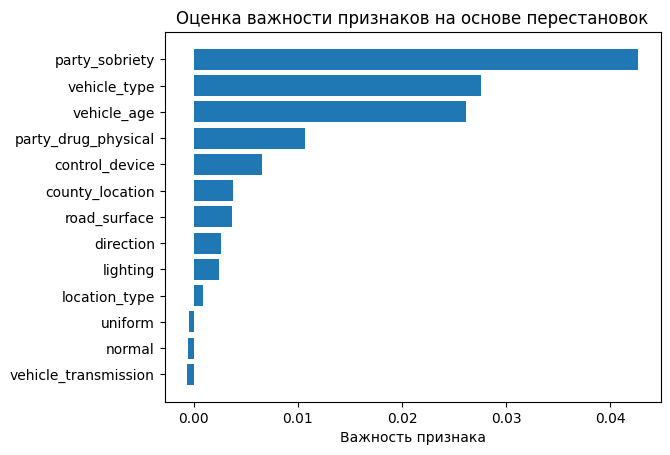

In [69]:
# Оценка важности признаков на основе перестановок
np.random.seed(RANDOM_STATE)
X_train_perm = X_train.copy()
X_test_perm = X_test.copy()

# Преобразование категориальных признаков в числовые
encoder = ce.LeaveOneOutEncoder().fit(X_train_perm[cat_cols], Y_train)
X_train_perm[cat_cols] = encoder.transform(X_train_perm[cat_cols])
X_test_perm[cat_cols] = encoder.transform(X_test_perm[cat_cols])

# Нормализация числовых признаков
scaler = pr_ng.StandardScaler().fit(X_train_perm[cat_cols + num_cols])
X_train_perm[cat_cols + num_cols] = scaler.transform(X_train_perm[cat_cols + num_cols])
X_test_perm[cat_cols + num_cols] = scaler.transform(X_test_perm[cat_cols + num_cols])

# Добавляем случайные признаки с равномерным и нормальным распределениями
X_train_perm['uniform'] = np.random.uniform(-1, 1, len(X_train_perm))
X_train_perm['normal'] = np.random.normal(-1, 1, len(X_train_perm))
X_test_perm['uniform'] = np.random.uniform(-1, 1, len(X_test_perm))
X_test_perm['normal'] = np.random.normal(-1, 1, len(X_test_perm))

m_dtc = xgb.XGBClassifier(random_state=RANDOM_STATE, verbosity=0)
m_dtc.fit(X_train_perm, Y_train)

result = permutation_importance(m_dtc, X_test_perm, Y_test, n_repeats=100, random_state=RANDOM_STATE)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train_perm.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Важность признака')
plt.title('Оценка важности признаков на основе перестановок')
plt.show()

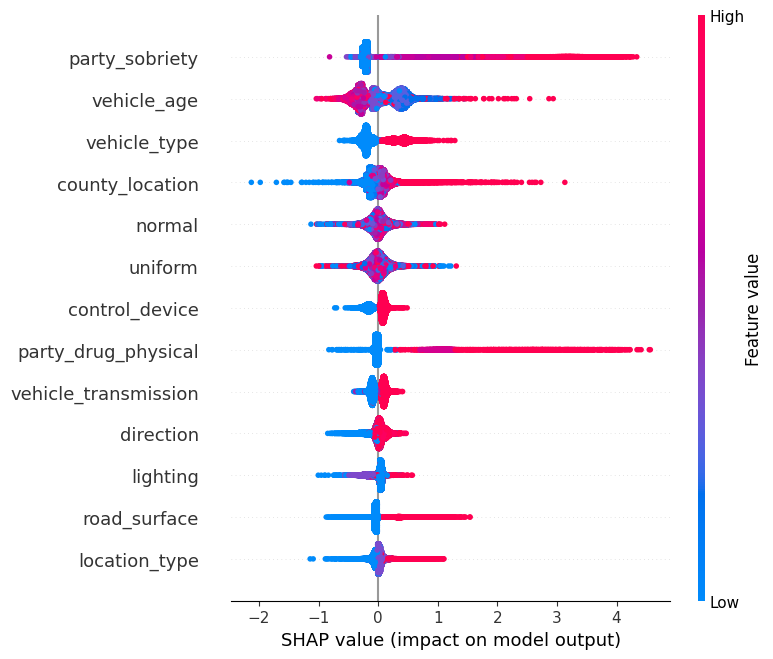

In [70]:
# Выполним оценку значимости признаков используя shap
explainer = shap.TreeExplainer(m_dtc)
shap_values = explainer.shap_values(X_train_perm)
shap.summary_plot(explainer.shap_values(X_train_perm), X_train_perm)

В ходе исследования были выявлены признаки `'cellphone_in_use'` `'road_condition_1'` `'weather_1'` `'month'` `'hour'`, удаление которых приводило в целом к улучшению рассматриваемых метрик. Отмечу, что при каждом обновлении SQL запроса, важность признаков меняется, вне зависимости от фиксации **RANDOM_STATE**, что в итоге потребовало многократного повторения опыта, начиная от SQL запроса и ориентация на наиболее частые результаты. Причин такого поведения данных (при запросах) выявить не удалось.

Наиболее подходящие признаки, для создания ML сервиса следующие:
- Трезвость участника происшествия `'party_sobriety'` - наиболее показательный признак для исследования. Согласно общеизвестной статистике, алкогольное опьянение увеличивает риск аварии в десятки раз. Это связано с тем, что алкоголь влияет на реакцию, координацию движений и восприятие окружающей среды.
- Тип кузова автомобиля `'vehicle_typer'` представленны двумя значениями 'coupe' и 'sedan'. Согласно полученымрафикам, видно 'coupe' имеют большую вероятность стать виновником аварии, чем 'sedan'.
- Возраст автомобиля `'vehicle_age'` - очень высокие значения признака сильно влияют на вероятность стать виновником аварии и напротив, очень низкие значения признака так же значительно влияет на вероятность стать виновником аварии, при этом средние значения возраста автомобиля дают большую вероятность быть не виновником аварии. Данные результаты согласуются со статистиков, в которой автомобили младше 5 лет чаще попадают в аварии, чем более старые модели. 
- Географический район `'county_location'` - явно выделяются районы, где вероятность аварии выше или ниже. Однако данный признак будет значительнее более точный и показательный если использовать данные не о количестве аварий, а о количестве аварий на 100 тыс. автомобилей. Тем не менее географический район может влиять на аварийность, так как количество ДТП с пострадавшими в разных регионах может существенно различаться.
- Устройства управления `'control_device'` - устройства управления могут влиять на аварийность, если они неисправны или неправильно установлены. В этом случае они могут вызвать сбой в работе автомобиля, что может привести к аварии. На графике видно, что автомобили с неисправными устройствами управления в большей степени влияет на вероятность виновности в аварии и напротив автомобили с исправным устройством управления с большей вероятностью влияет на невиновность.
- Состояние участника: физическое или с учётом принятых лекарств`'party_drug_physical'` - некоторые лекарства могут вызвать головокружение, потерю внимательности, что приведёт к ухудшению реакции.
- Тип КПП `'vehicle_transmission'` - очень слабо, но оказывает влияние на аварийность. Например, если автомобиль имеет ручную коробку передач, то водитель может быть более склонен к ошибкам при переключении передач, что может привести к аварии. С другой стороны, автомобили с автоматической коробкой передач могут быть более безопасными, так как они не требуют от водителя переключения передач вручную, что может уменьшить вероятность ошибок водителя1.
- Тип дороги `'location_type'` - перекрёстки могут быть опасными местами для вождения, так как они могут быть перегружены транспортом и пешеходами, а также могут иметь сложную геометрию, что затрудняет движение. Шоссе и рампы хоть и характеризуются более высокими скоростями движения, однако эти участки движения автомобилей более предсказуемы и контролируемы.
- Состояние дороги `'road_surface'` - сухое покрытие обычно считается наиболее безопасным, поскольку оно обеспечивает наилучшее сцепление между шинами и дорогой. Мокрое покрытие может быть опасным, потому что оно может уменьшить сцепление между шинами и дорогой, что может привести к заносу или аквапланированию. Скользкое покрытие, такое как лёд или снег, может быть наиболее опасным, потому что оно может сильно уменьшить сцепление между шинами и дорогой, что может привести к потере контроля над автомобилем. В целом, состояние дорожного покрытия может влиять на аварийность на дорогах, потому что различные состояния дорожного покрытия могут иметь различные характеристики, которые могут повышать или понижать риск аварий.
- Освещение `'lighting'` - недостаточное освещение может затруднить видимость дороги и других транспортных средств, что может привести к авариям. Кроме того, недостаточное освещение может затруднить видимость дорожных знаков и разметки, что может привести к неправильному поведению водителей. С другой стороны, слишком яркое освещение (расположение солнца над горизонтом) может затруднить видимость и привести к авариям. В целом, освещенность дороги может влиять на аварийность на дорогах, потому что видимость является важным фактором для безопасного вождения.

### Обучение моделей ML

Для решения поставленной задачи важным моментом является определения наибольшего количества ситуаций, которые могут привести к аварии. И напротив, для получения прибыли компании требуется сдавать автомобили в аренду, и мы не можем позволить себе отказывать в аренде слишком большому количеству клиентов. Таким образом одним из решений может является поиск наилучшей производительности модели по F1 метрики, при условии, что recall будет не менее 0.99. Далее, регулируя thresholds, ML можно подстроить под задачи бизнеса.

In [71]:
# Список иследуемых метрик
scoring = {
    'average_precision': make_scorer(average_precision_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
    }

In [72]:
# Подбор оптимальных гиперпараметров для DecisionTreeClassifier
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
            
        if trial.suggest_categorical('depth', [True, False]): # Максимальная глубина дерева
            max_depth = trial.suggest_int('max_depth', 1, 100)
        else:
            max_depth = None
        
        if trial.suggest_categorical('features', [True, False]): # Количество признаков, необходимых для одного ветвления
            max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
        else:
            max_features = None

        if trial.suggest_categorical('weight_fraction_leaf', [True, False]): # Минимальная доля суммарных весов (всех входных образцов), необходимую для нахождения в листе
            min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0, 0.5, step=0.01)
        else:
            min_weight_fraction_leaf = 0.0

        if trial.suggest_categorical('leaf_nodes', [True, False]): # Максимальное количество листовых узлов
            max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, int(X_train.shape[0]/X_train.shape[1]))
        else:
            max_leaf_nodes = None

        if trial.suggest_categorical('impurity_decrease', [True, False]): # Значение для уменьшения неопределенности, при котором узел будет разделен
            min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0, 1, step=0.0001)
        else:
            min_impurity_decrease = 0.0

        mdtc = DecisionTreeClassifier(
            random_state=RANDOM_STATE, # Определение случайности для разделения на узлы
            max_depth=max_depth,
            max_features=max_features,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            class_weight=trial.suggest_categorical('class_weight', [None, 'balanced']), # Веса классов при обучении модели, по умолчанию None
            criterion=trial.suggest_categorical('criterion', ['gini','entropy','log_loss']), # Aункция для измерения качества разделения, по умолчанию 'gini'
            splitter=trial.suggest_categorical('splitter', ['best','random']), # Стратегия выбора разделения, по умолчанию 'best'
            min_samples_split=trial.suggest_int('min_samples_split', 2, 100), # Минимальное количество образцов, необходимых для разделения внутреннего узла, по умолчанию 2
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100) # Минимальное количество образцов, требуемых для присутствия в листовом узле, по умолчанию 1
            )
        num_pipe = Pipeline([('scaler', pr_ng.Normalizer())])
        column_transf = ColumnTransformer(transformers=[('encoder', ce.LeaveOneOutEncoder(), cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf),('num_pipe', num_pipe),('classifier', mdtc)])
        scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=10)

        if np.mean(scores['test_recall']) < 0.99:
            raise optuna.TrialPruned()
        else:
            trial.set_user_attr('output_values', np.round([
                np.mean(scores['test_recall']), 
                np.mean(scores['test_f1']),
                np.mean(scores['test_roc_auc'])
            ], 3))
        return np.mean(scores['test_f1'])
    
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('output_values')
        if score is not None:
            print(f'Trial {trial.number}: output_values={score}')

    study = optuna.create_study(direction='maximize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner()
                                )
    study.optimize(objective, n_trials=1000, timeout=None, n_jobs=6, callbacks=[custom_callback])
else:
    print('''
Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 0
Лучшее значение целевой метрики: 0.6705627376983518
''')
    mdtc = DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=None,
        max_features=6,
        min_weight_fraction_leaf=0.31,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0002,
        class_weight=None,
        criterion='log_loss',
        splitter='random',
        min_samples_split=99,
        min_samples_leaf=19
    )
    num_pipe = Pipeline([('scaler', pr_ng.Normalizer())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.CatBoostEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mdtc)])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=10)

    print('Значение recall:', np.mean(scores['test_recall']))
    print('Значение precision:', np.round(np.mean(scores['test_precision']),3))
    print('Значение f1:', np.round(np.mean(scores['test_f1']),3))
    print('Значение average_precision:', np.round(np.mean(scores['test_average_precision']),3))


Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 0
Лучшее значение целевой метрики: 0.6705627376983518

Значение recall: 1.0
Значение precision: 0.504
Значение f1: 0.67
Значение average_precision: 0.504


Лучший результат: `Trial 5 finished with value: 0.6705627376983518 and parameters: {'depth': False, 'features': True, 'max_features': 6, 'weight_fraction_leaf': True, 'min_weight_fraction_leaf': 0.31, 'leaf_nodes': False, 'impurity_decrease': True, 'min_impurity_decrease': 0.0002, 'class_weight': None, 'criterion': 'log_loss', 'splitter': 'random', 'min_samples_split': 99, 'min_samples_leaf': 19} output_values=[1.    0.671 0.504 ]`

Модель DecisionTreeClassifier за 1000 итераций предсказаний не выдала метрики лучше случайной изначальной. Можно предположить, что данный классификатор прекрасно виде виновника аварии, а поскольку масса признаков для виновника и не виновника аграрии будет идентично, то деревянная модель не в состоянии их сколько-либо приемлемо разделить.

In [73]:
# Подбор оптимальных гиперпараметров для XGBClassifier
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        mxgb = xgb.XGBClassifier(
            random_state=RANDOM_STATE, # Определение случайности для разделения на узлы
            n_estimators=trial.suggest_int('n_estimators', 10, 1000), # Количество базовых моделей (деревьев) в ансамбле, по умолчанию 100
            learning_rate=trial.suggest_float('learning_rate', 0.001, 0.1, step=0.001), # Скорость обучения модели, по умолчанию 0.1
            max_depth=trial.suggest_int('max_depth', 1, 10), # Максимальная глубина каждого базового дерева, по умолчанию 6
            booster=trial.suggest_categorical('booster', ['gbtree','gblinear']), # Тип базовых моделей, которые используются в ансамбле, по умолчанию 'gbtree' ('dart' требует много вычислений)
            subsample=trial.suggest_float('subsample', 0.1, 1, step=0.01), # Доля образцов, используемых для обучения каждого базового дерева, по умолчанию 1
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.1, 1, step=0.01), # Доля признаков, используемых для обучения каждого базового дерева, по умолчанию 1
            gamma=trial.suggest_float('gamma', 0, 10, step=0.01), # Минимальное изменение функции потерь, которое требуется для создания нового разделения в базовых деревьях, по умолчанию 0
            reg_alpha=trial.suggest_float('reg_alpha', 0, 10, step=0.01), # Коэффициент регуляризации для L1-регуляризации базовых деревьев, по умолчанию 0
            reg_lambda=trial.suggest_float('reg_lambda', 0, 10, step=0.01), # Коэффициент регуляризации для L2-регуляризации базовых деревьев, по умолчанию 1
            #scale_pos_weight=trial.suggest_float('scale_pos_weight', 0, 10, step=0.01), # Вес положительного класса в случае несбалансированных данных, по умолчанию 1
            eval_metric=trial.suggest_categorical('eval_metric', ['error']), # Метрика для оценки качества модели во время обучения, по умолчанию 'error'
            objective=trial.suggest_categorical('objective', ['binary:logistic']), # Функция потерь, которая оптимизируется при обучении модели, по умолчанию 'binary:logistic'
            verbosity=0,
            #tree_method='gpu_hist', predictor='gpu_predictor' # Вычисления на GPU
            )
        num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
        column_transf = ColumnTransformer(transformers=[('encoder', ce.LeaveOneOutEncoder(), cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mxgb)])
        scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

        if np.mean(scores['test_recall']) < 0.99:
            raise optuna.TrialPruned()
        else:
            trial.set_user_attr('output_values', np.round([
                np.mean(scores['test_recall']), 
                np.mean(scores['test_f1']),
                np.mean(scores['test_roc_auc'])
            ], 3))
        return np.mean(scores['test_f1'])
    
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('output_values')
        if score is not None:
            print(f'Trial {trial.number}: output_values={score}')

    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner()
        )
    study.optimize(objective, n_trials=1, timeout=None, n_jobs=1, callbacks=[custom_callback])
else:
    print('''
Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 0
Лучшее значение целевой метрики: 0.6705627422996947
''')
    mxgb = xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        n_estimators=214,
        learning_rate=0.096,
        max_depth=10,
        booster='gbtree',
        subsample=0.29,
        colsample_bytree=0.31,
        gamma=1.56,
        reg_alpha=6.64,
        reg_lambda=6.09,
        scale_pos_weight=1,
        eval_metric='error',
        objective='binary:logistic',
        verbosity=0
        )
    num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.LeaveOneOutEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mxgb)])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=10)

    print('Значение recall:', np.mean(scores['test_recall']))
    print('Значение precision:', np.round(np.mean(scores['test_precision']),3))
    print('Значение f1:', np.round(np.mean(scores['test_f1']),3))
    print('Значение average_precision:', np.round(np.mean(scores['test_average_precision']),3))


Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 0
Лучшее значение целевой метрики: 0.6705627422996947

Значение recall: 1.0
Значение precision: 0.504
Значение f1: 0.67
Значение average_precision: 0.504


Лучший результат: `Trial 1 finished with value: 0.6705627422996947 and parameters: {'n_estimators': 214, 'learning_rate': 0.096, 'max_depth': 10, 'booster': 'gbtree', 'subsample': 0.29, 'colsample_bytree': 0.31, 'gamma': 1.56, 'reg_alpha': 6.64, 'reg_lambda': 6.09, 'eval_metric': 'error', 'objective': 'binary:logistic'} output_values=[1.    0.671 0.504]`

Модель XGBClassifier за 1000 итераций предсказаний не выдала метрики лучше случайной изначальной. Можно предположить, что данный классификатор прекрасно виде виновника аварии, а поскольку масса признаков для виновника и не виновника аграрии будет идентично, то бустинговая модель не в состоянии их сколько-либо приемлемо разделить.

In [74]:
# Подбор оптимальных гиперпараметров для LGBMClassifier
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        if trial.suggest_categorical('depth', [True, False]): # Максимальная глубина дерева, по умолчанию -1
            max_depth = trial.suggest_int('max_depth', 1, 10)
        else:
            max_depth = -1

        if trial.suggest_categorical('split_gain', [True, False]): # Минимальное увеличение значения функции потерь, необходимое для разделения узла дерева, по умолчанию 0
            min_split_gain = trial.suggest_float('min_split_gain', 0, 10, step=0.01)
        else:
            min_split_gain = 0

        mlgb = lgb.LGBMClassifier(
            random_state=RANDOM_STATE, # Определение случайности для разделения на узлы
            max_depth=max_depth,
            min_split_gain=min_split_gain,
            n_estimators=trial.suggest_int('n_estimators', 10, 1000), # Количество базовых моделей (деревьев) в ансамбле, по умолчанию 100
            boosting_type=trial.suggest_categorical('boosting_type', ['gbdt','goss']), # Тип градиентного бустинга, по умолчанию 'gbdt' ('dart' требует много вычислений)
            num_leaves=trial.suggest_int('num_leaves', 10, 100), # Число листьев в дереве, по умолчанию 31
            learning_rate=trial.suggest_float('learning_rate', 0.001, 0.1, step=0.001), # Шаг обучения модели, по умолчанию 0.1
            subsample_for_bin=trial.suggest_int('subsample_for_bin', 200000, 500000), # Количество выборок для построения гистограмм, по умолчанию 200000
            min_child_samples=trial.suggest_int('min_child_samples', 1, 100), # Минимальное количество образцов, необходимых в листовом узле, по умолчанию 20
            subsample=trial.suggest_float('subsample', 0.1, 1, step=0.01), # Доля образцов, используемых для обучения каждого базового дерева, по умолчанию 1
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.1, 1, step=0.01), # Доля признаков, используемых для обучения каждого базового дерева, по умолчанию 1
            objective=trial.suggest_categorical('objective', ['binary']), # Функция потерь, которая оптимизируется при обучении модели, по умолчанию 'binary:logistic'
            verbosity=-1
            )
        num_pipe = Pipeline([('scaler', pr_ng.Normalizer())])
        column_transf = ColumnTransformer(transformers=[('encoder', ce.QuantileEncoder(), cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mlgb)])
        scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

        if np.mean(scores['test_recall']) < 0.60:
            raise optuna.TrialPruned()
        else:
            trial.set_user_attr('output_values', np.round([
                np.mean(scores['test_recall']), 
                np.mean(scores['test_f1']),
                np.mean(scores['test_roc_auc'])
            ], 3))
        return np.mean(scores['test_f1'])
    
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('output_values')
        if score is not None:
            print(f'Trial {trial.number}: output_values={score}')

    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner()
        )
    study.optimize(objective, n_trials=1000, timeout=None, n_jobs=1, callbacks=[custom_callback])
else:
    print('''
Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 147
Лучшее значение целевой метрики: 0.6720035555820834
''')
    mlgb = lgb.LGBMClassifier(
        random_state=RANDOM_STATE,
        max_depth=3,
        min_split_gain=8.97,
        n_estimators=34,
        boosting_type='goss',
        num_leaves=58,
        learning_rate=0.001,
        subsample_for_bin=457292,
        min_child_samples=90,
        subsample=0.52,
        colsample_bytree=0.23,
        objective='binary',
        verbosity=-1
        )
    num_pipe = Pipeline([('scaler', pr_ng.Normalizer())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.QuantileEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mlgb)])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

    print('Значение recall:', np.mean(scores['test_recall']))
    print('Значение precision:', np.round(np.mean(scores['test_precision']),3))
    print('Значение f1:', np.round(np.mean(scores['test_f1']),3))
    print('Значение average_precision:', np.round(np.mean(scores['test_average_precision']),3))


Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 147
Лучшее значение целевой метрики: 0.6720035555820834

Значение recall: 0.9827439290110902
Значение precision: 0.511
Значение f1: 0.672
Значение average_precision: 0.511


Лучший результат: `Trial 147 finished with value: 0.6720035555820834 and parameters: {'depth': True, 'max_depth': 3, 'split_gain': True, 'min_split_gain': 8.97, 'n_estimators': 34, 'boosting_type': 'goss', 'num_leaves': 58, 'learning_rate': 0.001, 'subsample_for_bin': 457292, 'min_child_samples': 90, 'subsample': 0.52, 'colsample_bytree': 0.23, 'objective': 'binary'} output_values=[0.993 0.672 0.506]`

Модель LGBMClassifier за 1000 итераций предсказаний показал последовательное улучшение целевой метрики, однако её велична не превзошла результаты предсказаний остальных ML. Однако данная модель получила наиболее высокое значение roc_auc.

Поскольку результаты вышеописанных моделей довольно слабые но вера в чудо сохраняется, обратимся к нейросетевому моделированию.

In [75]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.optim as optim

# Нормализация числовых данных
scal = pr_ng.StandardScaler().fit(X_train[num_cols])
X_train_scal = pd.DataFrame(scal.transform(X_train[num_cols]), columns=num_cols)
X_test_scal = pd.DataFrame(scal.transform(X_test[num_cols]), columns=num_cols)

# Приведение категориальных признаков к числовому типу данных
ohe = pr_ng.OneHotEncoder(handle_unknown='error', sparse=False, drop='first').fit(X_train[cat_cols])
X_train_enc = pd.DataFrame(ohe.transform(X_train[cat_cols]), columns=ohe.get_feature_names_out(cat_cols))
X_test_enc = pd.DataFrame(ohe.transform(X_test[cat_cols]), columns=ohe.get_feature_names_out(cat_cols))

X_train_enc_scal = pd.concat([X_train_enc, X_train_scal], axis=1)
X_test_enc_scal = pd.concat([X_test_enc, X_test_scal], axis=1)

print('Размеры выборок:', X_train_enc_scal.shape, X_test_enc_scal.shape, Y_train.shape, Y_test.shape)

X_train_nn = torch.FloatTensor(np.ascontiguousarray(X_train_enc_scal.values))
X_test_nn = torch.FloatTensor(np.ascontiguousarray(X_test_enc_scal.values))
Y_train_nn = torch.FloatTensor(np.ascontiguousarray(Y_train.values))
Y_test_nn = torch.FloatTensor(np.ascontiguousarray(Y_test.values))

del scal, X_train_scal, X_test_scal, ohe, X_train_enc, X_test_enc, X_train_enc_scal, X_test_enc_scal

Размеры выборок: (43563, 89) (10891, 89) (43563,) (10891,)


In [76]:
def cross_validate_MLP_without_batches_(
        model: nn.Sequential,
        data: torch.FloatTensor,
        target: torch.FloatTensor,
        loss_functions: nn.BCELoss,
        optimizer: torch.optim,
        n_splits: int,
        num_epochs: int,
        gpu: bool
        ) -> pd.DataFrame:
    '''
    Функция, для обучения нейросети на кросвалидации с использованием GPU, без батчей.
    Функция обеспечивает минимизацию функции потерь.
    На выходе получаем списки функции потерь, лучших эпох и метрик: recall, f1, average_precision предсказания для test и train.
    '''
    if gpu:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
    
    train_loss_list = []
    test_loss_list = []
    
    iteration = 0
    metrics = pd.DataFrame() # Список параметров для каждого фолда
    cv = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)
    for train_index, test_index in cv.split(data, target):
        if gpu:
            X_train_cv, X_test_cv = data[train_index].to(device), data[test_index].to(device)
            Y_train_cv, Y_test_cv = target[train_index].to(device), target[test_index].to(device)
        else:
            X_train_cv, X_test_cv = data[train_index], data[test_index]
            Y_train_cv, Y_test_cv = target[train_index], target[test_index]

        train_list = []
        test_list = []

        metric_loss_best = 0
        epohs_best = 0
        for n_epohs in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            train_preds = model.forward(X_train_cv).flatten()
            train_loss = loss_functions(train_preds, Y_train_cv)
            train_loss.backward()
            optimizer.step()
            model.eval()
            test_preds = model.forward(X_test_cv).flatten()
            test_loss = loss_functions(test_preds, Y_test_cv)

            # Создаём списки для loss графика для каждого фолда
            train_list.append(train_loss.item())
            test_list.append(test_loss.item())

            # Прогназируем оптимальный результат на каждом фолде
            metric_loss = test_loss.item() - abs(test_loss.item() - train_loss.item())
            metric_loss_best, epohs_best = (metric_loss, n_epohs) if metric_loss > metric_loss_best else (metric_loss_best, epohs_best)

        train_loss_list.append(train_list)
        test_loss_list.append(test_list)
        
        if gpu:
            preds = test_preds.cpu().detach().numpy()
            y_targ = Y_test_cv.cpu().detach().numpy()
        else:
            preds = test_preds.detach().numpy()
            y_targ = Y_test_cv.detach().numpy()

        metrics.loc[iteration, 'loss_best'] = metric_loss_best
        metrics.loc[iteration, 'epohs'] = epohs_best
        metrics.loc[iteration, 'recall'] = recall_score(y_targ, preds > 0.5)
        metrics.loc[iteration, 'precision'] = precision_score(y_targ, preds > 0.5)
        metrics.loc[iteration, 'f1'] = f1_score(y_targ, preds > 0.5)
        metrics.loc[iteration, 'average_precision'] = average_precision_score(y_targ, preds)
        iteration += 1

    return metrics, [np.mean(t) for t in zip(*train_loss_list)], [np.mean(t) for t in zip(*test_loss_list)]

a_f = {
    'sigmoid': nn.Sigmoid(),
    'relu': nn.ReLU(),
    'prelu': nn.PReLU(),
    'tanh': nn.Tanh(),
    'elu': nn.ELU(),
    'identity': nn.Identity(),
    'leaky_relu': nn.LeakyReLU(),
    'softplus': nn.Softplus(),
    'selu': nn.SELU()
}
list_fa = ['sigmoid','relu','prelu','tanh','elu','identity','leaky_relu','softplus','selu']


Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 105
Лучшее значение целевой метрики: 0.6706974471723464



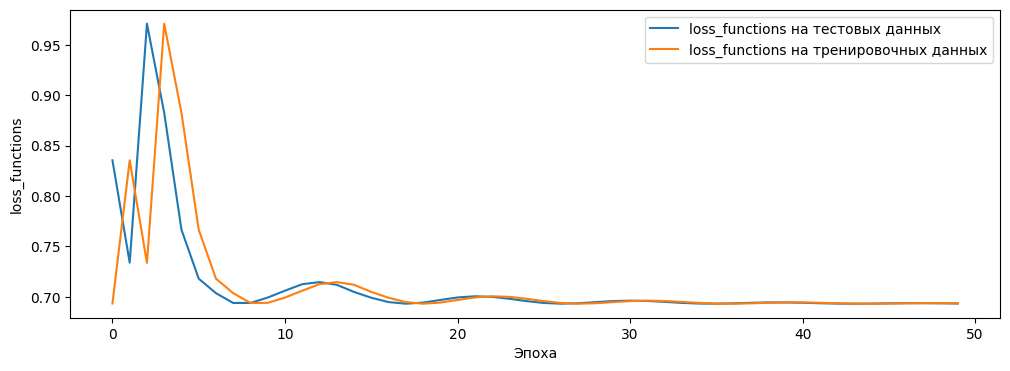

loss_best            0.794
epohs                9.200
recall               1.000
precision            0.504
f1                   0.670
average_precision    0.504
dtype: float64


In [77]:
# Подбор оптимальной архитектуры для MLP
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        n_layer = trial.suggest_int('n_layer', 1, 10, step=1) # Количество скрытых слоёв
        n_neurons = [X_train_nn.shape[1]] # Список количества нейронов
        activ_funct = [] # Установка списка ФА для слоёв кроме последнего
        net_layers = [] # Архетектура сети
        max_neurons = int(X_train_nn.shape[1] * np.sqrt(X_train_nn.shape[1]))
        if n_layer >= 1:
            n_neurons.append(trial.suggest_int('n_neurons_1', 1, max_neurons, step=5))
            activ_funct.append(a_f[trial.suggest_categorical('activ_funct_1', list_fa)])
            if n_layer >= 2:
                n_neurons.append(trial.suggest_int('n_neurons_2', 1, max_neurons, step=5))
                activ_funct.append(a_f[trial.suggest_categorical('activ_funct_2', list_fa)])
                if n_layer >= 3:
                    n_neurons.append(trial.suggest_int('n_neurons_3', 1, max_neurons, step=5))
                    activ_funct.append(a_f[trial.suggest_categorical('activ_funct_3', list_fa)])
                    if n_layer >= 4:
                        n_neurons.append(trial.suggest_int('n_neurons_4', 1, max_neurons, step=5))
                        activ_funct.append(a_f[trial.suggest_categorical('activ_funct_4', list_fa)])
                        if n_layer >= 5:
                            n_neurons.append(trial.suggest_int('n_neurons_5', 1, max_neurons, step=5))
                            activ_funct.append(a_f[trial.suggest_categorical('activ_funct_5', list_fa)])
                            if n_layer >= 6:
                                n_neurons.append(trial.suggest_int('n_neurons_6', 1, max_neurons, step=5))
                                activ_funct.append(a_f[trial.suggest_categorical('activ_funct_6', list_fa)])
                                if n_layer >= 7:
                                    n_neurons.append(trial.suggest_int('n_neurons_7', 1, max_neurons, step=5))
                                    activ_funct.append(a_f[trial.suggest_categorical('activ_funct_7', list_fa)])
                                    if n_layer >= 8:
                                        n_neurons.append(trial.suggest_int('n_neurons_8', 1, max_neurons, step=5))
                                        activ_funct.append(a_f[trial.suggest_categorical('activ_funct_8', list_fa)])
                                        if n_layer >= 9:
                                            n_neurons.append(trial.suggest_int('n_neurons_9', 1, max_neurons, step=5))
                                            activ_funct.append(a_f[trial.suggest_categorical('activ_funct_9', list_fa)])
                                            if n_layer >= 10:
                                                n_neurons.append(trial.suggest_int('n_neurons_10', 1, max_neurons, step=5))
                                                activ_funct.append(a_f[trial.suggest_categorical('activ_funct_10', list_fa)])
        n_neurons.append(1)

        for i in range(1, len(n_neurons) - 1): # Создаём список с архитектурой сети
            net_layers.append(nn.Linear(n_neurons[i-1], n_neurons[i]))
            net_layers.append(activ_funct[i-1])
        net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
        net_layers.append(nn.Sigmoid())
        nn_model = nn.Sequential(*net_layers) # Инициализируем MLP

        loss_functions = nn.BCELoss()
        optimizer = torch.optim.Adam(nn_model.parameters(), lr=trial.suggest_float('optimizer_Adam_ir', 0.0001, 0.01, step=0.0001))
        metrics, _, _ = cross_validate_MLP_without_batches_(nn_model, X_train_nn, Y_train_nn, loss_functions, optimizer, 3, 150, True)

        if np.mean(metrics['recall']) < 0.99:
            raise optuna.TrialPruned()
        else:
            trial.set_user_attr('output_values',[
                np.round(np.mean(metrics['loss_best']),3), 
                np.round(np.mean(metrics['recall']),3),
                np.round(np.mean(metrics['average_precision']),3),
                metrics['epohs'].values
            ])
        return np.mean(metrics['f1'])
    
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('output_values')
        if score is not None:
            print(f'Trial {trial.number}: output_values={score}')

    study = optuna.create_study(
        direction='maximize', sampler=TPESampler(seed=RANDOM_STATE), 
        study_name='torch',
        #storage='sqlite:///my_study_torch.db',
        #load_if_exists=True
        )
    study.optimize(objective, n_trials=1000, timeout=None, n_jobs=1, callbacks=[custom_callback])
else:
    print('''
Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 105
Лучшее значение целевой метрики: 0.6706974471723464
''')
    nn_model = nn.Sequential(
        nn.Linear(X_train_nn.shape[1], 96), nn.LeakyReLU(),
        nn.Linear(96, 141), nn.SELU(),
        nn.Linear(141, 486), nn.Identity(),
        nn.Linear(486, 766), nn.LeakyReLU(),
        nn.Linear(766, 736), nn.SELU(),
        nn.Linear(736, 266), nn.LeakyReLU(),
        nn.Linear(266, 91), nn.Tanh(),
        nn.Linear(91, 1), nn.Sigmoid()
    )
    loss_functions = nn.BCELoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.0097)
    metrics, train_loss_list, test_loss_list = cross_validate_MLP_without_batches_(nn_model, X_train_nn, Y_train_nn, loss_functions, optimizer, 5, 50, False)

    plt.figure(figsize=(12, 4))
    plt.plot(test_loss_list, label='loss_functions на тестовых данных')
    plt.plot(train_loss_list, label='loss_functions на тренировочных данных')
    plt.xlabel('Эпоха')
    plt.ylabel('loss_functions')
    plt.legend()
    plt.show()

    print(round(metrics.mean(), 3))

Лучший результат: `Trial 105 finished with value: 0.6706974471723464 and parameters: {'n_layer': 7, 'n_neurons_1': 96, 'activ_funct_1': 'leaky_relu', 'n_neurons_2': 141, 'activ_funct_2': 'selu', 'n_neurons_3': 486, 'activ_funct_3': 'identity', 'n_neurons_4': 766, 'activ_funct_4': 'leaky_relu', 'n_neurons_5': 736, 'activ_funct_5': 'selu', 'n_neurons_6': 266, 'activ_funct_6': 'leaky_relu', 'n_neurons_7': 91, 'activ_funct_7': 'tanh', 'optimizer_Adam_ir': 0.0097} output_values=[0.864, 0.999, 0.5, array([  2.,   1., 148.])]`

Нейросетевое моделирование показало схожие результаты с ансамблевыми моделями и демонстрирует стабильное обучение.

Резюмируя вышеизложенную работу приходим к выводу, что ML в целом прекрасно определяет положительный класс, и очень слабо негативный класс. Фактически единственной метрикой, по которой было возможно с той или иной степенью определить наилучшую производительность модели, является average_precision. Наилучшие результаты показала LGBMClassifier, продемонстрировав лучшею метрику average_precision.

| Модели классификации       | recall | precision |   f1   | average_precision |
| -------------------------- | ------ | --------- | ------ | ----------------- |
| DecisionTreeClassifier     | 1.000  | 0.504     | 0.671  | 0.504             |
| XGBClassifier              | 1.000  | 0.504     | 0.671  | 0.504             |
| LGBMClassifier             | 0.997  | 0.506     | 0.671  | 0.506             |
| NeuralNetworkModel         | 0.900  | 0.454     | 0.604  | 0.500             |

### Тестирование лучшей модели ML

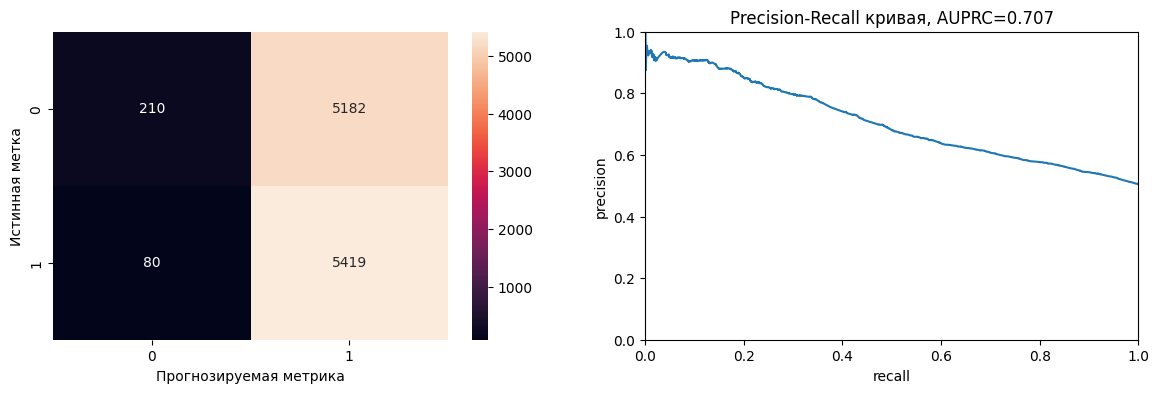

Значение recall: 0.985
Значение precision: 0.511
Значение f1: 0.673
Значение roc_auc: 0.707


In [78]:
# Тестирование лучшей модели
mlgb = lgb.LGBMClassifier(
    random_state=RANDOM_STATE,
    max_depth=3,
    min_split_gain=8.97,
    n_estimators=34,
    boosting_type='goss',
    num_leaves=58,
    learning_rate=0.001,
    subsample_for_bin=457292,
    min_child_samples=90,
    subsample=0.52,
    colsample_bytree=0.23,
    objective='binary',
    verbosity=-1
    )
num_pipe = Pipeline([('scaler', pr_ng.Normalizer())])
column_transf = ColumnTransformer(transformers=[('encoder', ce.QuantileEncoder(), cat_cols)], remainder='passthrough')
pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mlgb)])
pipeline.fit(X_train, Y_train)
predict = pipeline.predict(X_test)

prob = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(Y_test, prob, pos_label=None, sample_weight=None)

# Получаем графики и метрики с тестевой выборки
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict)), annot=True, fmt='g', ax=axs[0]) # Матрица путаницы
axs[0].set(xlabel='Прогнозируемая метрика', ylabel='Истинная метка')
axs[1].plot(recall, precision) # AUPRC-кривая
axs[1].set_title(f'Precision-Recall кривая, AUPRC={average_precision_score(Y_test, prob).round(3)}');
axs[1].set(xlabel='recall', ylabel='precision')
axs[1].set_xlim(xmin=0, xmax=1)
axs[1].set_ylim(ymin=0, ymax=1)
plt.show()

print('Значение recall:', np.round(recall_score(Y_test, predict),3))
print('Значение precision:', np.round(precision_score(Y_test, predict),3))
print('Значение f1:', np.round(f1_score(Y_test, predict),3))
print('Значение AUPRC:', np.round(np.mean(average_precision_score(Y_test, prob)),3))

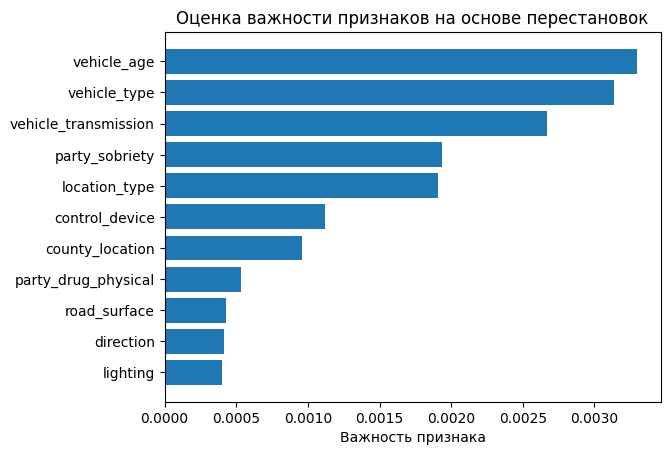

In [79]:
result = permutation_importance(pipeline, X_train, Y_train, n_repeats=100, random_state=RANDOM_STATE)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train_perm.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Важность признака')
plt.title('Оценка важности признаков на основе перестановок')
plt.show()

Результаты тестирования выбранной ML показывают сильную метрику определения положительного класса recall=0.985 и весьма хорошие метрики f1=0.673 и AUPRC=0.707, но при всём это модель очень плохо определяет истинную метку положительного класса precision=0.511, и распознаёт правильно мтолько 51,7% меток. По сути мы практически не видим тех наблюдений, которые не приводят к авариям. Данную ситуацию можно объяснить несколькими причинами:

1. Большинство исследуемых признаков для таргета будут схожи. Необходимо найти иной целевой признак, который бы в большей (более разнообразной) степени характеризовал каждого из участника (автомобиля) происшествия.
2. В процессе оптимизации гиперпараметров, оптимальный результат целевой метрики находился практически сразу, и при дальнейшей оптимизации не менялся. Это можно объяснить очень слабой классифицирующими свойствами всего совокупности данных. Нам не хватает гораздо большего количества разнообразных признаков для получения градиента, который мог бы более эффективно разделить положительный и негативный классы, к примеру:
    - признаков о техническом состоянии автомобиля, таких как срок после последнего ТО, количество ДТП, различные характеристики, обеспечивающее дополнительную управляемость на дороге и т.д.
    - признаки, характеризующие опыт и навыки водителя, такие как стаж, количество попаданий в ДТП, срок вождения без попаданий в ДТП или нарушения правил ДД, возраст, группа допуска к управлению автомобилем и т.д.
    - признаки, характеризующие транспортные потоки по выбранным маршрутам движения, скоростной режим, количество перекрёстков и т.д.
    
Проведение дополнительного сбора данных и их исследование поможет значительно повысить качество работы сервиса.

Оценка важности признаков на основе перестановок демонстрирует 3 наиболее важных, с точки зрения подготовленной ML, признака `'vehicle_age'`, `'vehicle_type'`, `'vehicle_transmission'`. Все эти признаки характеризуют состояние автомобиле, попавшего в аварию. Так же высокое значение имеют признаки `'party_sobryety'` и `'location_type'`. Остальные признаки, характеризующие в основном место аварии заметно менее слабые, что на мой взгляд связано с выбранным таргетом.

## Собственное решение задачи

Поскольку получить новые признаки мы не можем, для повышения качества текущего решения, попробуем переопределить целевой признак, который наилучшем образом отражал решение поставлено цели. Таким признаком решено выбрать `'collision_damage'`, который в отличии от `'at_fault'` не привязывает категории 0 и 1 к местности (виновник и не виновник взаимодействуют в одиноких условиях местности аварии), и даёт возможность признакам локации инцидента классифицировать категории. Как поступить с данным признаком есть несколько вариантов:
1. Решение задачи бинарной классификации: обозначим за 0 минимальные повреждения 'scratch', за 1 более серьёзные.
2. Решение задачи много классовой классификации, осуществляя поиск наиболее вероятной категории.
3. Решения задачи регрессии, где можно определять серьёзность повреждения от 0 до 5, согласно количеству категории.

Наиболее перспективной кажется регрессионная постановка задачи, которая нам даёт более подробные предсказания, однако за неимением времени выбор падает на задачу бинарной классификации.

Выезд на дорогу — это всегда риск получить повреждения, таким образом мы будет обучать модель определять, когда риск получить минимальные повреждения наиболее вероятен, нежели второй вариант, что напрямую решает задачу бизнеса о оптимизации расходов.

In [110]:
df_raw = '''
WITH
  tabl AS (
    SELECT 
      ps.case_id,
      ps.party_number,
      cs.county_location,
      cs.direction,
      cs.weather_1,
      cs.location_type,
      cs.road_surface,
      cs.road_condition_1,
      cs.lighting,
      cs.control_device,
      cs.collision_date,
      cs.collision_time,
      ps.party_sobriety,
      ps.party_drug_physical,
      ps.cellphone_in_use,
      ps.party_type,
      cs.collision_damage
    FROM parties AS ps
    LEFT JOIN collisions AS cs ON ps.case_id = cs.case_id
  )
SELECT 
  vs.vehicle_type,
  vs.vehicle_transmission,
  vs.vehicle_age,
  tb.county_location,
  tb.direction,
  tb.weather_1,
  tb.location_type,
  tb.road_surface,
  tb.road_condition_1,
  tb.lighting,
  tb.control_device,
  tb.party_sobriety,
  tb.party_drug_physical,
  tb.cellphone_in_use,
  tb.party_type,
  tb.collision_damage,
  EXTRACT(MONTH FROM tb.collision_date)::int AS month,
  EXTRACT(HOUR FROM tb.collision_time)::int AS hour
FROM vehicles AS vs
LEFT JOIN tabl AS tb ON vs.case_id = tb.case_id AND vs.party_number = tb.party_number
WHERE 
  tb.party_type = 'car'
  AND EXTRACT(YEAR FROM tb.collision_date) = 2012
'''
df_raw = pd.read_sql_query(df_raw, con=engine)
display(df_raw.head())
df_raw.info()

,vehicle_type,vehicle_transmission,vehicle_age,county_location,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,party_sobriety,party_drug_physical,cellphone_in_use,party_type,collision_damage,month,hour
0,coupe,manual,11.0,san bernardino,east,clear,highway,dry,normal,dusk or dawn,functioning,had not been drinking,None,0.0,car,middle damage,1,19.0
1,coupe,manual,8.0,los angeles,east,clear,highway,dry,normal,daylight,none,had not been drinking,None,0.0,car,scratch,1,11.0
2,coupe,manual,3.0,orange,east,cloudy,None,wet,holes,daylight,functioning,had not been drinking,None,0.0,car,scratch,1,16.0
3,sedan,manual,5.0,san bernardino,south,clear,ramp,dry,normal,dark with no street lights,none,had not been drinking,None,0.0,car,small damage,1,20.0
4,coupe,manual,8.0,sonoma,north,clear,None,dry,normal,daylight,none,had not been drinking,None,0.0,car,scratch,1,16.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103267 entries, 0 to 103266
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vehicle_type          103267 non-null  object 
 1   vehicle_transmission  101309 non-null  object 
 2   vehicle_age           100606 non-null  float64
 3   county_location       103267 non-null  object 
 4   direction             75818 non-null   object 
 5   weather_1             102962 non-null  object 
 6   location_type         43323 non-null   object 
 7   road_surface          102484 non-null  object 
 8   road_condition_1      102722 non-null  object 
 9   lighting              102934 non-null  object 
 10  control_device        102791 non-null  object 
 11  party_sobriety        101673 non-null  object 
 12  party_drug_physical   4340 non-null    object 
 13  cellphone_in_use      93264 non-null   float64
 14  party_type            103267 non-null  object 
 15  

In [111]:
# Подчищае строчные данные
df_raw = df_raw.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
df_raw = df_raw.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

# Обработка пропусков
df_raw.vehicle_transmission = df_raw.vehicle_transmission.fillna('unknown')
df_raw.direction = df_raw.direction.fillna('unknown')
df_raw.weather_1 = df_raw.weather_1.fillna('other')
df_raw.location_type = df_raw.location_type.fillna('unknown')
df_raw.road_surface = df_raw.road_surface.fillna('unknown')
df_raw.road_condition_1 = df_raw.road_condition_1.fillna('other')
df_raw.lighting = df_raw.lighting.fillna('unknown')
df_raw.control_device = df_raw.control_device.fillna('none')
df_raw.party_sobriety = df_raw.party_sobriety.fillna('not applicable')
df_raw.party_drug_physical = df_raw.party_drug_physical.fillna('not applicable')
df_raw.cellphone_in_use = df_raw.cellphone_in_use.fillna(0)
df_raw = df_raw.dropna()

# Количество и доля пропусков в данных
passes_share = pd.DataFrame(df_raw.isna().sum(), columns=['passes'])
passes_share['share_%'] = passes_share['passes'] * 100 / len(df_raw)
passes_share.style.background_gradient('coolwarm')

,passes,share_%
vehicle_type,0,0.000000
vehicle_transmission,0,0.000000
vehicle_age,0,0.000000
county_location,0,0.000000
direction,0,0.000000
weather_1,0,0.000000
location_type,0,0.000000
road_surface,0,0.000000
road_condition_1,0,0.000000
lighting,0,0.000000


In [112]:
# Подчищаем исключения в данных
df_raw = df_raw[df_raw.vehicle_type != 'other']
df_raw = df_raw[df_raw.vehicle_age < 16]

# Обозначаем за 0 - минимальные повреждения, за 1 - более серьёзные повреждения
df_raw['vehicle_type'] = df_raw['vehicle_type'].replace('sedan', 0).replace('coupe', 1)
df_raw['collision_damage'] = df_raw['collision_damage'].map({'scratch': 0, 'small damage': 1, 'middle damage': 1, 'severe damage': 1, 'fatal': 1})

# Определяем признаки, которые будут удалены из исследования
features_drop = ['party_type','cellphone_in_use','road_condition_1','weather_1']

# Отфильтровываем дубликаты
print(f'Количество дубликатов: {df_raw.drop(features_drop, axis=1).duplicated().sum()}')
df = df_raw.drop(features_drop, axis=1).dropna()

X_train, X_test, Y_train, Y_test = train_test_split(df.drop('collision_damage', axis=1), df['collision_damage'], test_size=0.2, random_state=RANDOM_STATE)

num_cols = ['vehicle_age']
cat_cols = list(set(X_train.columns) - set(num_cols))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

Количество дубликатов: 6334


((80374, 13), (20094, 13), (80374,), (20094,))

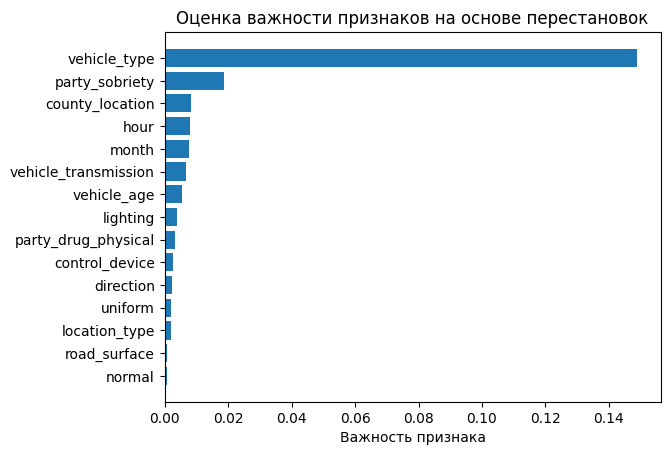

In [113]:
# Оценка важности признаков на основе перестановок
np.random.seed(RANDOM_STATE)
X_train_perm = X_train.copy()
X_test_perm = X_test.copy()

# Преобразование категориальных признаков в числовые
encoder = ce.LeaveOneOutEncoder().fit(X_train_perm[cat_cols], Y_train)
X_train_perm[cat_cols] = encoder.transform(X_train_perm[cat_cols])
X_test_perm[cat_cols] = encoder.transform(X_test_perm[cat_cols])

# Нормализация числовых признаков
scaler = pr_ng.StandardScaler().fit(X_train_perm[cat_cols + num_cols])
X_train_perm[cat_cols + num_cols] = scaler.transform(X_train_perm[cat_cols + num_cols])
X_test_perm[cat_cols + num_cols] = scaler.transform(X_test_perm[cat_cols + num_cols])

# Добавляем случайные признаки с равномерным и нормальным распределениями
X_train_perm['uniform'] = np.random.uniform(-1, 1, len(X_train_perm))
X_train_perm['normal'] = np.random.normal(-1, 1, len(X_train_perm))
X_test_perm['uniform'] = np.random.uniform(-1, 1, len(X_test_perm))
X_test_perm['normal'] = np.random.normal(-1, 1, len(X_test_perm))

m_dtc = xgb.XGBClassifier(random_state=RANDOM_STATE, verbosity=0)
m_dtc.fit(X_train_perm, Y_train)

result = permutation_importance(m_dtc, X_test_perm, Y_test, n_repeats=100, random_state=RANDOM_STATE)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train_perm.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Важность признака')
plt.title('Оценка важности признаков на основе перестановок')
plt.show()

В ходе исследования были выявлены признаки `'cellphone_in_use'` `'road_condition_1'` `'weather_1'`, удаление которых приводило в целом к улучшению рассматриваемых метрик. Отмечу, что при каждом обновлении SQL запроса, важность признаков меняется, вне зависимости от фиксации **RANDOM_STATE**. Использование нового целевого признака позволило признакам показать свою классификационную значимость `'month'` `'hour'`.

In [114]:
# Подбор оптимального алгоритма обработки признаков
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    num_pipe = Pipeline([
        ('scaler', pr_ng.StandardScaler())
    ])
    column_cat_transf = ColumnTransformer(transformers=[
        ('encoder', ce.TargetEncoder(), cat_cols)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('preproc_cat', column_cat_transf),
        ('num_pipe', num_pipe),
        ('classifier', None)
    ])
    param_grid = {
        'preproc_cat__encoder': encoder_type,
        'num_pipe__scaler': scaler_type
    }
    for name, model in class_models_type:
        pipeline.set_params(classifier=model)
        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            n_jobs=6,
            scoring=make_scorer(f1_score)
        )
        grid.fit(X_train, Y_train)
        print(f'{name}: {grid.best_params_}, {np.round(grid.best_score_,4)}, {np.round(np.mean(grid.cv_results_["mean_fit_time"]), 1)} сек')

Таблица результатов подбора оптимальных алгоритмов обработки признаков.

| Модели классификации       | f1     | scaler         | encoder            |
| -------------------------- | ------ | -------------- | ------------------ |
| LogisticRegression         | 0.7296 | StandardScaler | MEstimateEncoder   |
| DecisionTreeClassifier     | 0.7038 | StandardScaler | LeaveOneOutEncoder |
| RandomForestClassifier     | 0.7258 | MinMaxScaler   | CatBoostEncoder    |
| CatBoostClassifier         | 0.7335 | MinMaxScaler   | CatBoostEncoder    |
| XGBClassifier              | 0.7308 | StandardScaler | TargetEncoder      |
| LGBMClassifier             | 0.7355 | StandardScaler | CatBoostEncoder    |

In [115]:
# Подбор оптимальных гиперпараметров для LGBMClassifier
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        if trial.suggest_categorical('depth', [True, False]): # Максимальная глубина дерева, по умолчанию -1
            max_depth = trial.suggest_int('max_depth', 1, 10)
        else:
            max_depth = -1

        if trial.suggest_categorical('split_gain', [True, False]): # Минимальное увеличение значения функции потерь, необходимое для разделения узла дерева, по умолчанию 0
            min_split_gain = trial.suggest_float('min_split_gain', 0, 10, step=0.01)
        else:
            min_split_gain = 0

        mlgb = lgb.LGBMClassifier(
            random_state=RANDOM_STATE, # Определение случайности для разделения на узлы
            max_depth=max_depth,
            min_split_gain=min_split_gain,
            n_estimators=trial.suggest_int('n_estimators', 10, 1000), # Количество базовых моделей (деревьев) в ансамбле, по умолчанию 100
            boosting_type=trial.suggest_categorical('boosting_type', ['gbdt','goss']), # Тип градиентного бустинга, по умолчанию 'gbdt' ('dart' требует много вычислений)
            num_leaves=trial.suggest_int('num_leaves', 10, 100), # Число листьев в дереве, по умолчанию 31
            learning_rate=trial.suggest_float('learning_rate', 0.001, 0.1, step=0.001), # Шаг обучения модели, по умолчанию 0.1
            subsample_for_bin=trial.suggest_int('subsample_for_bin', 200000, 500000), # Количество выборок для построения гистограмм, по умолчанию 200000
            min_child_samples=trial.suggest_int('min_child_samples', 1, 100), # Минимальное количество образцов, необходимых в листовом узле, по умолчанию 20
            subsample=trial.suggest_float('subsample', 0.1, 1, step=0.01), # Доля образцов, используемых для обучения каждого базового дерева, по умолчанию 1
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.1, 1, step=0.01), # Доля признаков, используемых для обучения каждого базового дерева, по умолчанию 1
            objective=trial.suggest_categorical('objective', ['binary']), # Функция потерь, которая оптимизируется при обучении модели, по умолчанию 'binary:logistic'
            verbosity=-1
            )
        num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
        column_transf = ColumnTransformer(transformers=[('encoder', ce.CatBoostEncoder(), cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mlgb)])
        scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

        if np.mean(scores['test_recall']) < 0.99:
            raise optuna.TrialPruned()
        else:
            trial.set_user_attr('output_values', np.round([
                np.mean(scores['test_recall']), 
                np.mean(scores['test_f1']),
                np.mean(scores['test_average_precision'])
            ], 3))
        return np.mean(scores['test_f1'])
    
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('output_values')
        if score is not None:
            print(f'Trial {trial.number}: output_values={score}')

    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner()
        )
    study.optimize(objective, n_trials=None, timeout=None, n_jobs=1, callbacks=[custom_callback])
else:
    print('''
Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 176
Лучшее значение целевой метрики: 0.7103073701078119
''')
    mlgb = lgb.LGBMClassifier(
        random_state=RANDOM_STATE,
        max_depth=-1,
        min_split_gain=1.73,
        n_estimators=24,
        boosting_type='goss',
        num_leaves=81,
        learning_rate=0.007,
        subsample_for_bin=330634,
        min_child_samples=22,
        subsample=0.48,
        colsample_bytree=0.8,
        objective='binary',
        verbosity=-1
        )
    num_pipe = Pipeline([('scaler', pr_ng.Normalizer())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.QuantileEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mlgb)])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

    print('Значение recall:', np.mean(scores['test_recall']))
    print('Значение precision:', np.round(np.mean(scores['test_precision']),3))
    print('Значение f1:', np.round(np.mean(scores['test_f1']),3))
    print('Значение average_precision:', np.round(np.mean(scores['test_average_precision']),3))


Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 176
Лучшее значение целевой метрики: 0.7103073701078119

Значение recall: 0.9876897062281833
Значение precision: 0.554
Значение f1: 0.71
Значение average_precision: 0.554


Лучший результат:  `Trial 176 finished with value: 0.7103073701078119 and parameters: {'depth': False, 'split_gain': True, 'min_split_gain': 1.73, 'n_estimators': 24, 'boosting_type': 'goss', 'num_leaves': 81, 'learning_rate': 0.007, 'subsample_for_bin': 330634, 'min_child_samples': 22, 'subsample': 0.48, 'colsample_bytree': 0.8, 'objective': 'binary'} output_values=[0.991 0.71  0.553]`

In [116]:
# Подбор оптимальных гиперпараметров для CatBoostClassifier
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        mcbc = CatBoostClassifier(
            random_state=RANDOM_STATE, 
            verbose=False,
            task_type='GPU',
            random_strength=trial.suggest_float('random_strength', 0., 1, step=0.01),
            border_count=trial.suggest_int('border_count', 50, 300, step=5),
            iterations=trial.suggest_int('iterations', 1000, 10000, step=10),
            learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.1, step=0.0001),
            depth=trial.suggest_int('depth', 1, 10, step=1),
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.001, 100, log=True),
            bootstrap_type=trial.suggest_categorical('bootstrap_type', ['Bayesian']),
            bagging_temperature=trial.suggest_float('bagging_temperature', 0, 4, step=0.01),
            od_type=trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            leaf_estimation_method=trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
            grow_policy=trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
            )
        num_pipe = Pipeline([('scaler', pr_ng.MinMaxScaler())])
        column_transf = ColumnTransformer(transformers=[('encoder', ce.CatBoostEncoder(), cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mcbc)])
        scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=3)

        if np.mean(scores['test_recall']) < 0.6:
            raise optuna.TrialPruned()
        else:
            trial.set_user_attr('output_values', np.round([
                np.mean(scores['test_recall']), 
                np.mean(scores['test_f1']),
                np.mean(scores['test_average_precision'])
            ], 3))
        return np.mean(scores['test_f1'])

    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('output_values')
        if score is not None:
            print(f'Trial {trial.number}: output_values={score}')

    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner(),
        #study_name='CB',
        #storage='sqlite:///my_study_CB.db',
        #load_if_exists=True
        )
    study.optimize(objective, n_trials=None, timeout=None, n_jobs=1, callbacks=[custom_callback])
else:
    print('''
Количество завершенных испытаний: 55
Лучшее испытание завершено на итерации: 45
Лучшее значение целевой метрики: 0.737473
''')
    mcbc = CatBoostClassifier(
        random_state=RANDOM_STATE, 
        verbose=False,
        task_type='GPU',
        random_strength=0.05,
        border_count=250,
        iterations=6540,
        learning_rate=0.0058,
        depth=6,
        l2_leaf_reg=0.017338,
        bootstrap_type='Bayesian',
        bagging_temperature=3.19,
        od_type='IncToDec',
        leaf_estimation_method='Gradient',
        grow_policy='Depthwise'
        )
    num_pipe = Pipeline([('scaler', pr_ng.MinMaxScaler())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.CatBoostEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mcbc)])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

    print('Значение recall:', np.mean(scores['test_recall']))
    print('Значение precision:', np.round(np.mean(scores['test_precision']),3))
    print('Значение f1:', np.round(np.mean(scores['test_f1']),3))
    print('Значение average_precision:', np.round(np.mean(scores['test_average_precision']),3))


Количество завершенных испытаний: 55
Лучшее испытание завершено на итерации: 45
Лучшее значение целевой метрики: 0.737473

Значение recall: 0.7687406423540633
Значение precision: 0.71
Значение f1: 0.738
Значение average_precision: 0.671


Лучший результат: `Trial 45 finished with value: 0.737473 and parameters: {'random_strength': 0.05, 'border_count': 250, 'iterations': 6540, 'learning_rate': 0.0058, 'depth': 6, 'l2_leaf_reg': 0.017338, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.19, 'od_type': 'IncToDec', 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Depthwise'}`

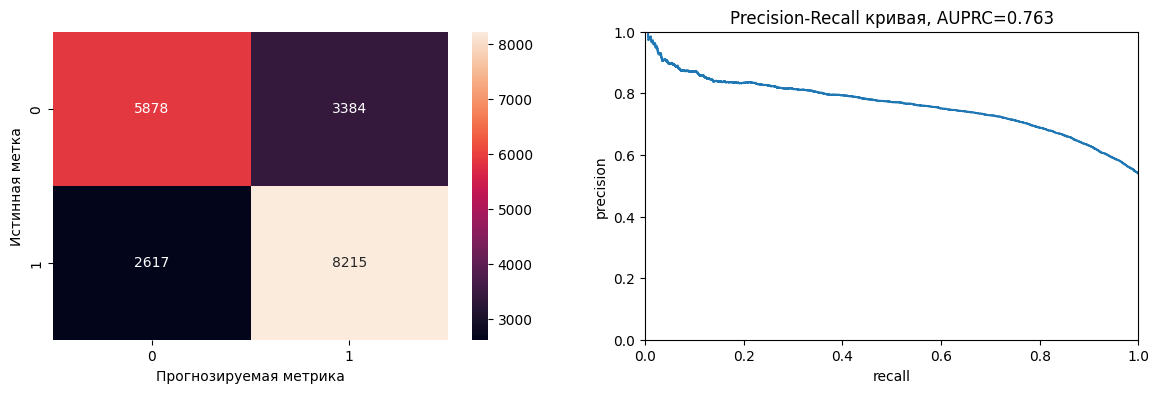

Значение recall: 0.758
Значение precision: 0.708
Значение f1: 0.732
Значение AUPRC: 0.763


In [117]:
# Тестирование лучшей модели
mcbc = CatBoostClassifier(
    random_state=RANDOM_STATE, 
    verbose=False,
    #task_type='GPU',
    random_strength=0.05,
    border_count=250,
    iterations=6540,
    learning_rate=0.0058,
    depth=6,
    l2_leaf_reg=0.017338,
    bootstrap_type='Bayesian',
    bagging_temperature=3.19,
    od_type='IncToDec',
    leaf_estimation_method='Gradient',
    grow_policy='Depthwise'
    )
num_pipe = Pipeline([('scaler', pr_ng.MinMaxScaler())])
column_transf = ColumnTransformer(transformers=[('encoder', ce.CatBoostEncoder(), cat_cols)], remainder='passthrough')
pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mcbc)])
pipeline.fit(X_train, Y_train)
predict = pipeline.predict(X_test)

prob = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(Y_test, prob, pos_label=None, sample_weight=None)

# Получаем графики и метрики с тестевой выборки
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict)), annot=True, fmt='g', ax=axs[0]) # Матрица путаницы
axs[0].set(xlabel='Прогнозируемая метрика', ylabel='Истинная метка')
axs[1].plot(recall, precision) # AUPRC-кривая
axs[1].set_title(f'Precision-Recall кривая, AUPRC={average_precision_score(Y_test, prob).round(3)}');
axs[1].set(xlabel='recall', ylabel='precision')
axs[1].set_xlim(xmin=0, xmax=1)
axs[1].set_ylim(ymin=0, ymax=1)
plt.show()

print('Значение recall:', np.round(recall_score(Y_test, predict),3))
print('Значение precision:', np.round(precision_score(Y_test, predict),3))
print('Значение f1:', np.round(f1_score(Y_test, predict),3))
print('Значение AUPRC:', np.round(np.mean(average_precision_score(Y_test, prob)),3))

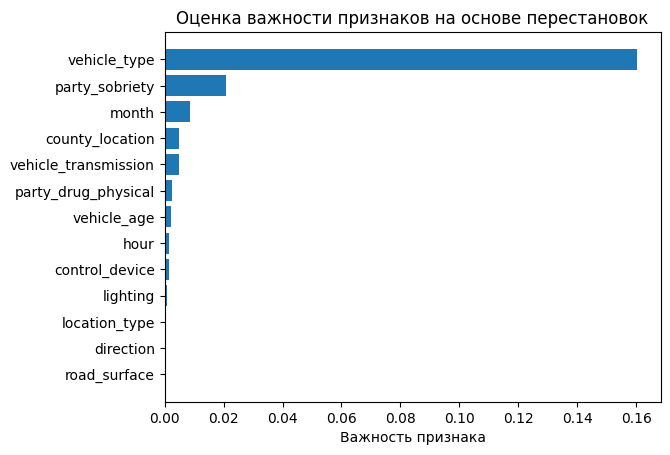

In [118]:
result = permutation_importance(pipeline, X_train, Y_train, n_repeats=10, random_state=RANDOM_STATE)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train_perm.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Важность признака')
plt.title('Оценка важности признаков на основе перестановок')
plt.show()

Модель показывает вполне приемлемые метрики производительности recall=0.751 и precision=0.719, и распознаёт 70,6% меток. Если получить дополнительные признаки, указанных в рекомендациях выше, модель может показать отличные рабочие показатели для бизнеса.

Таким образом можно утверждать, что ML решение на основе таргета `'collision_damage'` даёт более производительную модель, чем решение на основе таргета `'at_fault'`.

## Выводы

1. **Первичный осмотр данных.** Сформированная база данных включает 56248 наблюдения и 17 ретроспективных признака. Тем не менее база данных имеет явные недостатки:
- малое количество наблюдений. Не учитываются результаты наблюдений на предыдущие годы;
- данные представлены за одни год, в котором полноценно мы видим наблюдения за первых 5 месяцев, остальные месяцы представлены крайне слабо;
- признак возраста автомобиля имеет сомнительные значения возраста, более 100 лет.

2. **Исследовательский анализ данных.** 
    - Типы кузовоп автомобиля `'vehicle_typer'` представленны двумя значениями coupe и sedan. Неизвестный тип кузова представлен 4 единицами и есть смысл эти данные исключить.
    - Типы КПП `'vehicle_transmission'` представленны двумя значениями auto и manual, приблизительно со схожем соотношении.
    - Средний возраст автомобилей `'vehicle_age'` рассматриваемой таблицы 4,9 года. Наибольшая частота аварий характерна для трёхлетних автомобилей. Редкие значения возрастов (старше 15 лет) вероятно стоит убрать.
    - Наибольшая частота аварий `'county_location'` характерна для региона los angeles.
    - Большинство направлений движений `'direction'` при авариях не известно, вероятно по той причини что авария произошла на перекрёстке и определить направление движения невозможно.
    - Основное количество ДТП `'weather_1'` наблюдается в ясную и облачную погоду.
    - Основная доля ДТП `'location_type'` наблюдается на дорогах общего пользования, вне перекрёстков и рамп.
    - Основная доля ДТП `'road_surface'` происходит на сухих дорогах.
    - Основная доля ДТП `'road_condition_1'` происходит на дорогах в нормальном состоянии.
    - Основная доля ДТП `'lighting'` происходит днём или на освещённых улицах.
    - Основная доля ДТП `'control_device'` происходит с автомобилями у которых отсутствует устройство управления.
    - Соотношение долей участников ДТП `'at_fault'` по типу виновности практически идентично.
    - Основная доля ДТП `'party_sobriety'` происходит с участниками, не употреблявших алкоголь.
    - В большенстве случаев `'party_drug_physical'` наркологическая экспертиза участников ДТП не проводилась.
    - В большенстве случаев `'cellphone_in_use'` наркологическая экспертиза участников ДТП не проводилась.

3. **Разработка модели ML.** В ходе исследования были выявлены признаки `'cellphone_in_use'` `'road_condition_1'` `'weather_1'` `'month'` `'hour'`, удаление которых приводило в целом к улучшению рассматриваемых метрик. Наиболее подходящие признаки, для создания ML сервиса следующие:
    - Трезвость участника происшествия `'party_sobriety'` - наиболее показательный признак для исследования. Согласно общеизвестной статистике, алкогольное опьянение увеличивает риск аварии в десятки раз. Это связано с тем, что алкоголь влияет на реакцию, координацию движений и восприятие окружающей среды.
    - Тип кузова автомобиля `'vehicle_typer'` представленны двумя значениями 'coupe' и 'sedan'. Согласно полученымрафикам, видно 'coupe' имеют большую вероятность стать виновником аварии, чем 'sedan'.
    - Возраст автомобиля `'vehicle_age'` - очень высокие значения признака сильно влияют на вероятность стать виновником аварии и напротив, очень низкие значения признака так же значительно влияет на вероятность стать виновником аварии, при этом средние значения возраста автомобиля дают большую вероятность быть не виновником аварии. Данные результаты согласуются со статистиков, в которой автомобили младше 5 лет чаще попадают в аварии, чем более старые модели. 
    - Географический район `'county_location'` - явно выделяются районы, где вероятность аварии выше или ниже. Однако данный признак будет значительнее более точный и показательный если использовать данные не о количестве аварий, а о количестве аварий на 100 тыс. автомобилей. Тем не менее географический район может влиять на аварийность, так как количество ДТП с пострадавшими в разных регионах может существенно различаться.
    - Устройства управления `'control_device'` - устройства управления могут влиять на аварийность, если они неисправны или неправильно установлены. В этом случае они могут вызвать сбой в работе автомобиля, что может привести к аварии. На графике видно, что автомобили с неисправными устройствами управления в большей степени влияет на вероятность виновности в аварии и напротив автомобили с исправным устройством управления с большей вероятностью влияет на невиновность.
    - Состояние участника: физическое или с учётом принятых лекарств`'party_drug_physical'` - некоторые лекарства могут вызвать головокружение, потерю внимательности, что приведёт к ухудшению реакции.
    - Тип КПП `'vehicle_transmission'` - очень слабо, но оказывает влияние на аварийность. Например, если автомобиль имеет ручную коробку передач, то водитель может быть более склонен к ошибкам при переключении передач, что может привести к аварии. С другой стороны, автомобили с автоматической коробкой передач могут быть более безопасными, так как они не требуют от водителя переключения передач вручную, что может уменьшить вероятность ошибок водителя1.
    - Тип дороги `'location_type'` - перекрёстки могут быть опасными местами для вождения, так как они могут быть перегружены транспортом и пешеходами, а также могут иметь сложную геометрию, что затрудняет движение. Шоссе и рампы хоть и характеризуются более высокими скоростями движения, однако эти участки движения автомобилей более предсказуемы и контролируемы.
    - Состояние дороги `'road_surface'` - сухое покрытие обычно считается наиболее безопасным, поскольку оно обеспечивает наилучшее сцепление между шинами и дорогой. Мокрое покрытие может быть опасным, потому что оно может уменьшить сцепление между шинами и дорогой, что может привести к заносу или аквапланированию. Скользкое покрытие, такое как лёд или снег, может быть наиболее опасным, потому что оно может сильно уменьшить сцепление между шинами и дорогой, что может привести к потере контроля над автомобилем. В целом, состояние дорожного покрытия может влиять на аварийность на дорогах, потому что различные состояния дорожного покрытия могут иметь различные характеристики, которые могут повышать или понижать риск аварий.
    - Освещение `'lighting'` - недостаточное освещение может затруднить видимость дороги и других транспортных средств, что может привести к авариям. Кроме того, недостаточное освещение может затруднить видимость дорожных знаков и разметки, что может привести к неправильному поведению водителей. С другой стороны, слишком яркое освещение (расположение солнца над горизонтом) может затруднить видимость и привести к авариям. В целом, освещенность дороги может влиять на аварийность на дорогах, потому что видимость является важным фактором для безопасного вождения.

4. **Обучение моделей ML.** Постоенные ML в целом прекрасно определяет положительный класс, и очень слабо негативный класс. Фактически единственной метрикой, по которой было возможно с той или иной степенью определить наилучшую производительность модели, является average_precision. Наилучшие результаты показала LGBMClassifier, продемонстрировав лучшею метрику average_precision.

    | Модели классификации       | recall | precision |   f1   | average_precision |
    | -------------------------- | ------ | --------- | ------ | ----------------- |
    | DecisionTreeClassifier     | 1.000  | 0.504     | 0.671  | 0.504             |
    | XGBClassifier              | 1.000  | 0.504     | 0.671  | 0.504             |
    | LGBMClassifier             | 0.997  | 0.506     | 0.671  | 0.506             |
    | NeuralNetworkModel         | 0.900  | 0.454     | 0.604  | 0.500             |
<!-- Отступ между разделами -->
5. **Тестирование лучшей модели ML.** Результаты тестирования выбранной ML показывают сильную метрику определения положительного класса recall=0.985 и весьма хорошие метрики f1=0.673 и AUPRC=0.707, но при всём это модель очень плохо определяет истинную метку положительного класса precision=0.511. По сути мы практически не видим тех наблюдений, которые не приводят к авариям. Данную ситуацию можно объяснить несколькими причинами:

    1. Большинство исследуемых признаков для таргета будут схожи. Необходимо найти иной целевой признак, который бы в большей (более разнообразной) степени характеризовал каждого из участника (автомобиля) происшествия.
    2. В процессе оптимизации гиперпараметров, оптимальный результат целевой метрики находился практически сразу, и при дальнейшей оптимизации не менялся. Это можно объяснить очень слабой классифицирующими свойствами всего совокупности данных. Нам не хватает гораздо большего количества разнообразных признаков для получения градиента, который мог бы более эффективно разделить положительный и негативный классы, к примеру:
        - признаков о техническом состоянии автомобиля, таких как срок после последнего ТО, количество ДТП, различные характеристики, обеспечивающее дополнительную управляемость на дороге и т.д.
        - признаки, характеризующие опыт и навыки водителя, такие как стаж, количество попаданий в ДТП, срок вождения без попаданий в ДТП или нарушения правил ДД, возраст, группа допуска к управлению автомобилем и т.д.
        - признаки, характеризующие транспортные потоки по выбранным маршрутам движения, скоростной режим, количество перекрёстков и т.д.
    
    Проведение дополнительного сбора данных и их исследование поможет значительно повысить качество работы сервиса.

    Оценка важности признаков на основе перестановок демонстрирует 3 наиболее важных, с точки зрения подготовленной ML, признака `'vehicle_age'`, `'vehicle_type'`, `'vehicle_transmission'`. Все эти признаки характеризуют состояние автомобиле, попавшего в аварию. Так же высокое значение имеют признаки `'party_sobryety'` и `'location_type'`. Остальные признаки, характеризующие в основном место аварии заметно менее слабые, что на мой взгляд связано с выбранным таргетом.

6. **Собственное решение задачи.** Выполнено переопределение целевого признака на `'collision_damage'`. Выбран способ решения задачи бинарной классификации, где обозначено за 0 минимальные повреждения 'scratch', за 1 более серьёзные. Выезд на дорогу — это всегда риск получить повреждения, таким образом мы будет обучать модель определять, когда риск получить минимальные повреждения наиболее вероятен, нежели второй вариант, что напрямую решает задачу бизнеса о оптимизации расходов. Модель показывает вполне приемлемые метрики производительности recall=0.751 и precision=0.719, и распознаёт 70,6% меток. Если получить дополнительные признаки, указанных в рекомендациях выше, модель может показать отличные рабочие показатели для бизнеса. Таким образом можно утверждать, что ML решение на основе таргета `'collision_damage'` даёт более производительную модель, чем решение на основе таргета `'at_fault'`.
